# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

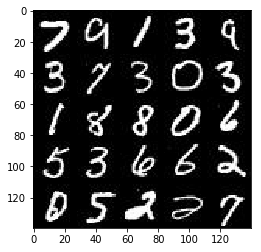

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

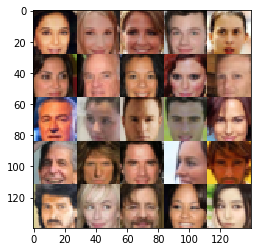

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_height , image_width , image_channels))
    input_z = tf.placeholder(tf.float32, (None, z_dim))  
    learning_rate = tf.placeholder(tf.float32)  
    
    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """   
    alpha = 0.2
    dropout = 0.8
    
    # kernel initializer
    kerinit = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=kerinit, padding='same')
        x1 = tf.nn.dropout(x1, dropout)
        x1 = tf.maximum(alpha * x1, x1)        
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, kernel_initializer=kerinit, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.nn.dropout(x2, dropout)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 7x7x128   
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, kernel_initializer=kerinit, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.nn.dropout(x3, dropout)
        x3 = tf.maximum(alpha * x3, x3)
        
        # 4x4x256 

        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)        
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """            
    alpha = 0.2 
    dropout = 0.8
    
    # kernel initializer
    kerinit = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope("generator", reuse = not is_train):
               
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)        
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)                
        x1 = tf.nn.dropout(x1, dropout)
        x1 = tf.maximum(alpha * x1, x1)           
        
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2,  kernel_initializer=kerinit, padding='same')
        # 7x7x128 now
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.dropout(x2, dropout)
        x2 = tf.maximum(alpha * x2, x2)
        

        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2,  kernel_initializer=kerinit, padding='same')
        # 14x14x64 now
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.dropout(x3, dropout)
        x3 = tf.maximum(alpha * x3, x3)
        
          
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim , 5, strides=1,  kernel_initializer=kerinit, padding='same')
        # 28x28xout_channel_dim now     
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
      
    tf.reset_default_graph()
       
    input_real, input_z, lr = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)        
    
    steps = 0
    print_every= 10
    show_every= 100

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Resize images ( -1 to 1)
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                # train twice generator for faster loss reduction 
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))                    

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
        show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
       

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.1044... Generator Loss: 0.5302
Epoch 1/2... Discriminator Loss: 1.6935... Generator Loss: 0.7658
Epoch 1/2... Discriminator Loss: 1.8831... Generator Loss: 0.5886
Epoch 1/2... Discriminator Loss: 1.7431... Generator Loss: 0.9822
Epoch 1/2... Discriminator Loss: 1.6360... Generator Loss: 1.0372
Epoch 1/2... Discriminator Loss: 1.7150... Generator Loss: 0.4843
Epoch 1/2... Discriminator Loss: 1.6131... Generator Loss: 0.7788
Epoch 1/2... Discriminator Loss: 1.6690... Generator Loss: 0.6432
Epoch 1/2... Discriminator Loss: 1.3811... Generator Loss: 0.7691
Epoch 1/2... Discriminator Loss: 1.6779... Generator Loss: 0.8114


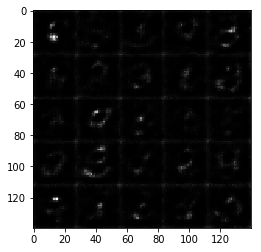

Epoch 1/2... Discriminator Loss: 1.3631... Generator Loss: 0.5877
Epoch 1/2... Discriminator Loss: 1.5532... Generator Loss: 0.9446
Epoch 1/2... Discriminator Loss: 1.4071... Generator Loss: 0.7573
Epoch 1/2... Discriminator Loss: 1.5127... Generator Loss: 1.1139
Epoch 1/2... Discriminator Loss: 1.5895... Generator Loss: 0.5886
Epoch 1/2... Discriminator Loss: 1.5470... Generator Loss: 0.7388
Epoch 1/2... Discriminator Loss: 1.5095... Generator Loss: 0.8913
Epoch 1/2... Discriminator Loss: 1.3536... Generator Loss: 1.0179
Epoch 1/2... Discriminator Loss: 1.3567... Generator Loss: 1.2453
Epoch 1/2... Discriminator Loss: 1.5224... Generator Loss: 0.9480


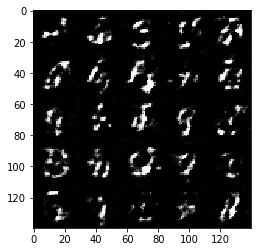

Epoch 1/2... Discriminator Loss: 1.2950... Generator Loss: 0.9660
Epoch 1/2... Discriminator Loss: 1.4008... Generator Loss: 0.7852
Epoch 1/2... Discriminator Loss: 1.1603... Generator Loss: 1.0455
Epoch 1/2... Discriminator Loss: 1.4255... Generator Loss: 1.0544
Epoch 1/2... Discriminator Loss: 1.4145... Generator Loss: 0.8753
Epoch 1/2... Discriminator Loss: 1.3164... Generator Loss: 1.0707
Epoch 1/2... Discriminator Loss: 1.3116... Generator Loss: 1.0949
Epoch 1/2... Discriminator Loss: 1.3401... Generator Loss: 0.9455
Epoch 1/2... Discriminator Loss: 1.2960... Generator Loss: 1.0025
Epoch 1/2... Discriminator Loss: 1.1384... Generator Loss: 0.9140


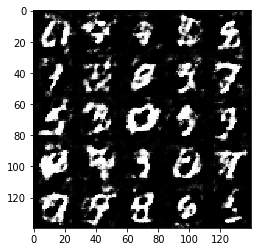

Epoch 1/2... Discriminator Loss: 1.2036... Generator Loss: 0.9669
Epoch 1/2... Discriminator Loss: 1.2851... Generator Loss: 1.1440
Epoch 1/2... Discriminator Loss: 1.1926... Generator Loss: 0.9589
Epoch 1/2... Discriminator Loss: 1.2506... Generator Loss: 1.0472
Epoch 1/2... Discriminator Loss: 1.1657... Generator Loss: 0.9552
Epoch 1/2... Discriminator Loss: 1.1129... Generator Loss: 1.0787
Epoch 1/2... Discriminator Loss: 1.1759... Generator Loss: 0.9314
Epoch 1/2... Discriminator Loss: 1.1779... Generator Loss: 0.9734
Epoch 1/2... Discriminator Loss: 1.1787... Generator Loss: 1.1534
Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 0.7767


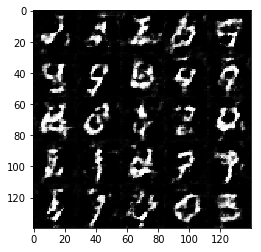

Epoch 1/2... Discriminator Loss: 1.3546... Generator Loss: 0.8818
Epoch 1/2... Discriminator Loss: 1.3309... Generator Loss: 1.0569
Epoch 1/2... Discriminator Loss: 1.3875... Generator Loss: 0.9709
Epoch 1/2... Discriminator Loss: 1.2439... Generator Loss: 0.9226
Epoch 1/2... Discriminator Loss: 1.4837... Generator Loss: 1.0226
Epoch 1/2... Discriminator Loss: 1.2926... Generator Loss: 1.3695
Epoch 1/2... Discriminator Loss: 1.3186... Generator Loss: 0.9510
Epoch 1/2... Discriminator Loss: 1.3613... Generator Loss: 0.8530
Epoch 1/2... Discriminator Loss: 1.3114... Generator Loss: 0.8429
Epoch 1/2... Discriminator Loss: 1.3407... Generator Loss: 1.1584


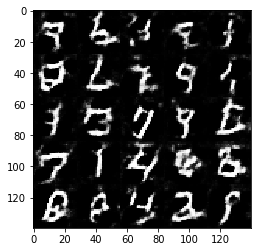

Epoch 1/2... Discriminator Loss: 1.2405... Generator Loss: 1.4891
Epoch 1/2... Discriminator Loss: 1.2101... Generator Loss: 1.0291
Epoch 1/2... Discriminator Loss: 1.4167... Generator Loss: 0.8378
Epoch 1/2... Discriminator Loss: 1.2016... Generator Loss: 1.3789
Epoch 1/2... Discriminator Loss: 1.2688... Generator Loss: 1.0623
Epoch 1/2... Discriminator Loss: 1.3633... Generator Loss: 1.5434
Epoch 1/2... Discriminator Loss: 1.4142... Generator Loss: 0.6599
Epoch 1/2... Discriminator Loss: 1.3470... Generator Loss: 1.0257
Epoch 1/2... Discriminator Loss: 1.2768... Generator Loss: 0.9715
Epoch 1/2... Discriminator Loss: 1.1496... Generator Loss: 0.7978


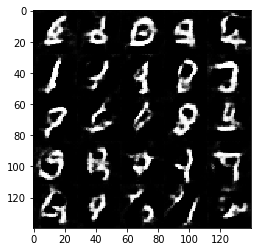

Epoch 1/2... Discriminator Loss: 1.4628... Generator Loss: 1.3129
Epoch 1/2... Discriminator Loss: 1.4391... Generator Loss: 0.7151
Epoch 1/2... Discriminator Loss: 1.1540... Generator Loss: 1.2425
Epoch 1/2... Discriminator Loss: 1.3551... Generator Loss: 1.0406
Epoch 1/2... Discriminator Loss: 1.3219... Generator Loss: 0.7197
Epoch 1/2... Discriminator Loss: 1.2229... Generator Loss: 0.8178
Epoch 1/2... Discriminator Loss: 1.2063... Generator Loss: 1.0259
Epoch 1/2... Discriminator Loss: 1.2597... Generator Loss: 0.9305
Epoch 1/2... Discriminator Loss: 1.2779... Generator Loss: 0.7907
Epoch 1/2... Discriminator Loss: 1.3595... Generator Loss: 1.0519


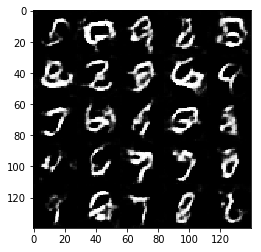

Epoch 1/2... Discriminator Loss: 1.2191... Generator Loss: 1.1847
Epoch 1/2... Discriminator Loss: 1.3769... Generator Loss: 0.9675
Epoch 1/2... Discriminator Loss: 1.1993... Generator Loss: 0.8503
Epoch 1/2... Discriminator Loss: 1.4132... Generator Loss: 0.9353
Epoch 1/2... Discriminator Loss: 1.2911... Generator Loss: 1.1512
Epoch 1/2... Discriminator Loss: 1.2450... Generator Loss: 1.0691
Epoch 1/2... Discriminator Loss: 1.1971... Generator Loss: 0.9366
Epoch 1/2... Discriminator Loss: 1.3316... Generator Loss: 0.7659
Epoch 1/2... Discriminator Loss: 1.4865... Generator Loss: 1.2429
Epoch 1/2... Discriminator Loss: 1.3348... Generator Loss: 1.0292


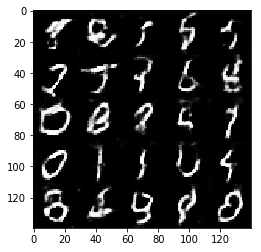

Epoch 1/2... Discriminator Loss: 1.2994... Generator Loss: 1.3012
Epoch 1/2... Discriminator Loss: 1.1326... Generator Loss: 1.1055
Epoch 1/2... Discriminator Loss: 1.3698... Generator Loss: 0.8705
Epoch 1/2... Discriminator Loss: 1.2606... Generator Loss: 0.9662
Epoch 1/2... Discriminator Loss: 1.2038... Generator Loss: 0.8978
Epoch 1/2... Discriminator Loss: 1.4020... Generator Loss: 1.1411
Epoch 1/2... Discriminator Loss: 1.1005... Generator Loss: 1.0657
Epoch 1/2... Discriminator Loss: 1.2079... Generator Loss: 1.0187
Epoch 1/2... Discriminator Loss: 1.2037... Generator Loss: 0.8004
Epoch 1/2... Discriminator Loss: 1.3508... Generator Loss: 0.8163


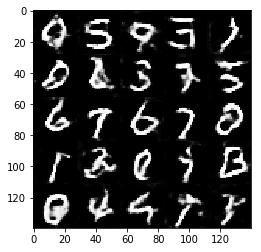

Epoch 1/2... Discriminator Loss: 1.2481... Generator Loss: 0.9672
Epoch 1/2... Discriminator Loss: 1.2939... Generator Loss: 0.8513
Epoch 1/2... Discriminator Loss: 1.1694... Generator Loss: 0.7594
Epoch 1/2... Discriminator Loss: 1.1939... Generator Loss: 0.8742
Epoch 1/2... Discriminator Loss: 1.5595... Generator Loss: 0.6657
Epoch 1/2... Discriminator Loss: 1.3411... Generator Loss: 0.9021
Epoch 1/2... Discriminator Loss: 1.4316... Generator Loss: 1.1307
Epoch 1/2... Discriminator Loss: 1.4626... Generator Loss: 0.9145
Epoch 1/2... Discriminator Loss: 1.4266... Generator Loss: 0.7628
Epoch 1/2... Discriminator Loss: 1.2430... Generator Loss: 0.7174


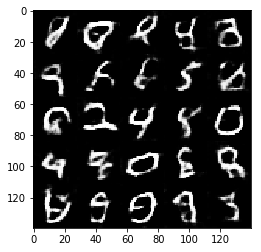

Epoch 1/2... Discriminator Loss: 1.3517... Generator Loss: 0.8130
Epoch 1/2... Discriminator Loss: 1.2819... Generator Loss: 1.0424
Epoch 1/2... Discriminator Loss: 1.2786... Generator Loss: 0.8557
Epoch 1/2... Discriminator Loss: 1.3455... Generator Loss: 1.0761
Epoch 1/2... Discriminator Loss: 1.2361... Generator Loss: 0.8798
Epoch 1/2... Discriminator Loss: 1.4312... Generator Loss: 0.8651
Epoch 1/2... Discriminator Loss: 1.2841... Generator Loss: 1.0600
Epoch 1/2... Discriminator Loss: 1.3370... Generator Loss: 0.7666
Epoch 1/2... Discriminator Loss: 1.2392... Generator Loss: 0.9880
Epoch 1/2... Discriminator Loss: 1.5053... Generator Loss: 0.9582


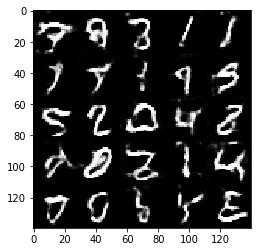

Epoch 1/2... Discriminator Loss: 1.1952... Generator Loss: 0.9291
Epoch 1/2... Discriminator Loss: 1.2353... Generator Loss: 1.0405
Epoch 1/2... Discriminator Loss: 1.3089... Generator Loss: 0.8688
Epoch 1/2... Discriminator Loss: 1.3579... Generator Loss: 0.7815
Epoch 1/2... Discriminator Loss: 1.2392... Generator Loss: 0.9525
Epoch 1/2... Discriminator Loss: 1.2606... Generator Loss: 0.7033
Epoch 1/2... Discriminator Loss: 1.2101... Generator Loss: 1.1753
Epoch 1/2... Discriminator Loss: 1.3962... Generator Loss: 0.8587
Epoch 1/2... Discriminator Loss: 1.3809... Generator Loss: 0.9807
Epoch 1/2... Discriminator Loss: 1.2114... Generator Loss: 0.9193


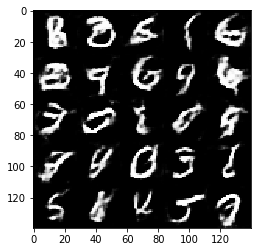

Epoch 1/2... Discriminator Loss: 1.3270... Generator Loss: 0.7965
Epoch 1/2... Discriminator Loss: 1.3825... Generator Loss: 1.0813
Epoch 1/2... Discriminator Loss: 1.2564... Generator Loss: 0.8843
Epoch 1/2... Discriminator Loss: 1.2197... Generator Loss: 1.0092
Epoch 1/2... Discriminator Loss: 1.2860... Generator Loss: 0.9836
Epoch 1/2... Discriminator Loss: 1.3436... Generator Loss: 0.7453
Epoch 1/2... Discriminator Loss: 1.3177... Generator Loss: 0.8920
Epoch 1/2... Discriminator Loss: 1.2459... Generator Loss: 1.0155
Epoch 1/2... Discriminator Loss: 1.4017... Generator Loss: 0.6119
Epoch 1/2... Discriminator Loss: 1.2474... Generator Loss: 1.2208


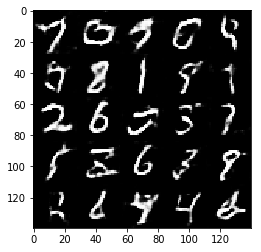

Epoch 1/2... Discriminator Loss: 1.3491... Generator Loss: 0.9069
Epoch 1/2... Discriminator Loss: 1.0820... Generator Loss: 0.9930
Epoch 1/2... Discriminator Loss: 1.2919... Generator Loss: 0.8090
Epoch 1/2... Discriminator Loss: 1.2696... Generator Loss: 0.9495
Epoch 1/2... Discriminator Loss: 1.2576... Generator Loss: 0.8474
Epoch 1/2... Discriminator Loss: 1.3759... Generator Loss: 0.8018
Epoch 1/2... Discriminator Loss: 1.3156... Generator Loss: 1.0025
Epoch 1/2... Discriminator Loss: 1.1964... Generator Loss: 1.0108
Epoch 1/2... Discriminator Loss: 1.2941... Generator Loss: 0.7303
Epoch 1/2... Discriminator Loss: 1.2455... Generator Loss: 1.2859


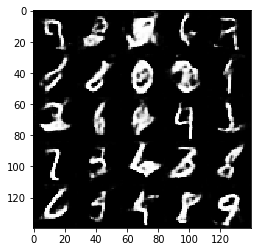

Epoch 1/2... Discriminator Loss: 1.2927... Generator Loss: 0.7550
Epoch 1/2... Discriminator Loss: 1.1273... Generator Loss: 1.4219
Epoch 1/2... Discriminator Loss: 1.2355... Generator Loss: 1.0234
Epoch 1/2... Discriminator Loss: 1.4235... Generator Loss: 0.6192
Epoch 1/2... Discriminator Loss: 1.2060... Generator Loss: 0.9205
Epoch 1/2... Discriminator Loss: 1.3007... Generator Loss: 1.0828
Epoch 1/2... Discriminator Loss: 1.1185... Generator Loss: 0.8786
Epoch 1/2... Discriminator Loss: 1.3165... Generator Loss: 1.0546
Epoch 1/2... Discriminator Loss: 1.3279... Generator Loss: 0.8996
Epoch 1/2... Discriminator Loss: 1.1705... Generator Loss: 0.9201


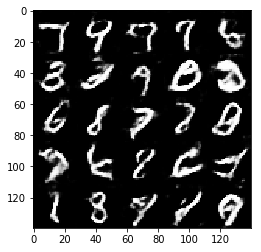

Epoch 1/2... Discriminator Loss: 1.2354... Generator Loss: 1.0419
Epoch 1/2... Discriminator Loss: 1.2532... Generator Loss: 0.8796
Epoch 1/2... Discriminator Loss: 1.3278... Generator Loss: 0.7861
Epoch 1/2... Discriminator Loss: 1.1947... Generator Loss: 0.9525
Epoch 1/2... Discriminator Loss: 1.2783... Generator Loss: 1.0322
Epoch 1/2... Discriminator Loss: 1.1670... Generator Loss: 1.1228
Epoch 1/2... Discriminator Loss: 1.2192... Generator Loss: 1.0690
Epoch 1/2... Discriminator Loss: 1.2376... Generator Loss: 1.1057
Epoch 1/2... Discriminator Loss: 1.3031... Generator Loss: 1.0586
Epoch 1/2... Discriminator Loss: 1.3288... Generator Loss: 0.9908


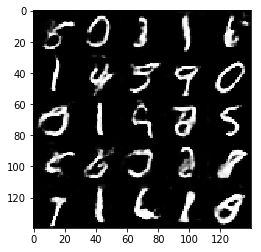

Epoch 1/2... Discriminator Loss: 1.2635... Generator Loss: 1.1198
Epoch 1/2... Discriminator Loss: 1.2588... Generator Loss: 0.8962
Epoch 1/2... Discriminator Loss: 1.3659... Generator Loss: 1.0816
Epoch 1/2... Discriminator Loss: 1.0331... Generator Loss: 0.8239
Epoch 1/2... Discriminator Loss: 1.2993... Generator Loss: 0.8351
Epoch 1/2... Discriminator Loss: 1.2513... Generator Loss: 1.1330
Epoch 1/2... Discriminator Loss: 1.3204... Generator Loss: 0.7873
Epoch 1/2... Discriminator Loss: 1.3468... Generator Loss: 0.7249
Epoch 1/2... Discriminator Loss: 1.1988... Generator Loss: 0.8360
Epoch 1/2... Discriminator Loss: 1.3071... Generator Loss: 0.8277


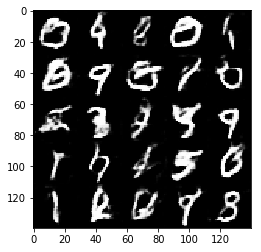

Epoch 1/2... Discriminator Loss: 1.1411... Generator Loss: 0.8806
Epoch 1/2... Discriminator Loss: 1.1915... Generator Loss: 0.8909
Epoch 1/2... Discriminator Loss: 1.1537... Generator Loss: 0.9913
Epoch 1/2... Discriminator Loss: 1.3739... Generator Loss: 0.9773
Epoch 1/2... Discriminator Loss: 1.2084... Generator Loss: 0.9886
Epoch 1/2... Discriminator Loss: 1.3558... Generator Loss: 0.8011
Epoch 1/2... Discriminator Loss: 1.2305... Generator Loss: 1.5272
Epoch 1/2... Discriminator Loss: 1.2344... Generator Loss: 0.7368
Epoch 1/2... Discriminator Loss: 1.2346... Generator Loss: 0.8229
Epoch 1/2... Discriminator Loss: 1.2916... Generator Loss: 0.9337


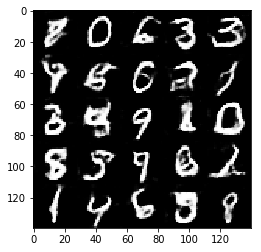

Epoch 1/2... Discriminator Loss: 1.3015... Generator Loss: 1.2242
Epoch 1/2... Discriminator Loss: 1.4970... Generator Loss: 0.8190
Epoch 1/2... Discriminator Loss: 1.3133... Generator Loss: 0.7571
Epoch 1/2... Discriminator Loss: 1.0985... Generator Loss: 0.7986
Epoch 1/2... Discriminator Loss: 1.2092... Generator Loss: 1.0991
Epoch 1/2... Discriminator Loss: 1.1881... Generator Loss: 1.1524
Epoch 1/2... Discriminator Loss: 1.3663... Generator Loss: 1.1453
Epoch 2/2... Discriminator Loss: 1.2560... Generator Loss: 1.0371
Epoch 2/2... Discriminator Loss: 1.2277... Generator Loss: 1.1272
Epoch 2/2... Discriminator Loss: 1.1815... Generator Loss: 1.0275


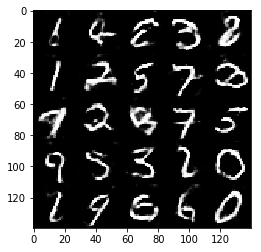

Epoch 2/2... Discriminator Loss: 1.2062... Generator Loss: 1.0983
Epoch 2/2... Discriminator Loss: 1.1428... Generator Loss: 1.1292
Epoch 2/2... Discriminator Loss: 1.1996... Generator Loss: 0.9493
Epoch 2/2... Discriminator Loss: 1.3021... Generator Loss: 1.0368
Epoch 2/2... Discriminator Loss: 1.2719... Generator Loss: 0.8344
Epoch 2/2... Discriminator Loss: 1.2609... Generator Loss: 0.7925
Epoch 2/2... Discriminator Loss: 1.4656... Generator Loss: 1.0392
Epoch 2/2... Discriminator Loss: 1.3153... Generator Loss: 1.0557
Epoch 2/2... Discriminator Loss: 1.1976... Generator Loss: 1.2130
Epoch 2/2... Discriminator Loss: 1.2806... Generator Loss: 0.8470


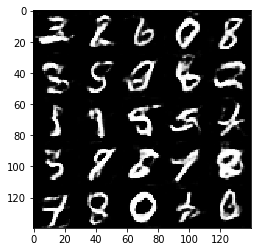

Epoch 2/2... Discriminator Loss: 1.5046... Generator Loss: 0.7557
Epoch 2/2... Discriminator Loss: 1.2100... Generator Loss: 1.0346
Epoch 2/2... Discriminator Loss: 1.1660... Generator Loss: 1.2405
Epoch 2/2... Discriminator Loss: 1.1103... Generator Loss: 1.1097
Epoch 2/2... Discriminator Loss: 1.3166... Generator Loss: 0.9797
Epoch 2/2... Discriminator Loss: 1.4598... Generator Loss: 0.7497
Epoch 2/2... Discriminator Loss: 1.3423... Generator Loss: 0.7584
Epoch 2/2... Discriminator Loss: 1.3416... Generator Loss: 0.8298
Epoch 2/2... Discriminator Loss: 1.2846... Generator Loss: 1.1478
Epoch 2/2... Discriminator Loss: 1.2527... Generator Loss: 1.0506


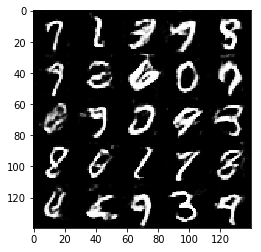

Epoch 2/2... Discriminator Loss: 1.2199... Generator Loss: 0.8563
Epoch 2/2... Discriminator Loss: 1.5120... Generator Loss: 0.7622
Epoch 2/2... Discriminator Loss: 1.1158... Generator Loss: 0.8838
Epoch 2/2... Discriminator Loss: 1.2345... Generator Loss: 0.9351
Epoch 2/2... Discriminator Loss: 1.2514... Generator Loss: 0.9116
Epoch 2/2... Discriminator Loss: 1.4918... Generator Loss: 0.7542
Epoch 2/2... Discriminator Loss: 1.3320... Generator Loss: 0.7713
Epoch 2/2... Discriminator Loss: 1.2789... Generator Loss: 0.8794
Epoch 2/2... Discriminator Loss: 1.3224... Generator Loss: 0.8237
Epoch 2/2... Discriminator Loss: 1.2837... Generator Loss: 1.1780


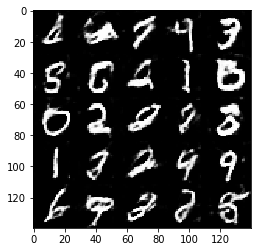

Epoch 2/2... Discriminator Loss: 1.2367... Generator Loss: 0.9498
Epoch 2/2... Discriminator Loss: 1.1870... Generator Loss: 0.9620
Epoch 2/2... Discriminator Loss: 1.3195... Generator Loss: 1.2622
Epoch 2/2... Discriminator Loss: 1.2687... Generator Loss: 1.2603
Epoch 2/2... Discriminator Loss: 1.2675... Generator Loss: 0.9928
Epoch 2/2... Discriminator Loss: 1.2596... Generator Loss: 1.0151
Epoch 2/2... Discriminator Loss: 1.3325... Generator Loss: 0.9309
Epoch 2/2... Discriminator Loss: 1.0828... Generator Loss: 0.9542
Epoch 2/2... Discriminator Loss: 1.2045... Generator Loss: 1.0313
Epoch 2/2... Discriminator Loss: 1.2823... Generator Loss: 0.8791


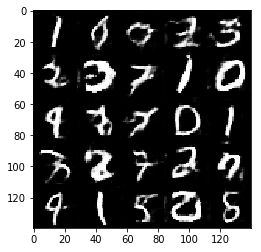

Epoch 2/2... Discriminator Loss: 1.2442... Generator Loss: 0.9928
Epoch 2/2... Discriminator Loss: 1.1836... Generator Loss: 0.9606
Epoch 2/2... Discriminator Loss: 1.3073... Generator Loss: 0.9683
Epoch 2/2... Discriminator Loss: 1.1800... Generator Loss: 1.0587
Epoch 2/2... Discriminator Loss: 1.4001... Generator Loss: 0.9419
Epoch 2/2... Discriminator Loss: 1.2845... Generator Loss: 0.9166
Epoch 2/2... Discriminator Loss: 1.3299... Generator Loss: 1.0147
Epoch 2/2... Discriminator Loss: 1.2201... Generator Loss: 1.0676
Epoch 2/2... Discriminator Loss: 1.3390... Generator Loss: 0.8303
Epoch 2/2... Discriminator Loss: 1.2340... Generator Loss: 0.8510


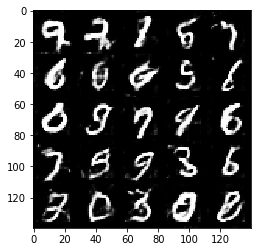

Epoch 2/2... Discriminator Loss: 1.1736... Generator Loss: 0.8040
Epoch 2/2... Discriminator Loss: 1.3483... Generator Loss: 0.7990
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 1.1437
Epoch 2/2... Discriminator Loss: 1.1165... Generator Loss: 1.0602
Epoch 2/2... Discriminator Loss: 1.1510... Generator Loss: 0.9682
Epoch 2/2... Discriminator Loss: 1.4027... Generator Loss: 1.1163
Epoch 2/2... Discriminator Loss: 1.1656... Generator Loss: 1.1334
Epoch 2/2... Discriminator Loss: 1.2948... Generator Loss: 0.7645
Epoch 2/2... Discriminator Loss: 1.2419... Generator Loss: 1.0024
Epoch 2/2... Discriminator Loss: 1.2349... Generator Loss: 0.8501


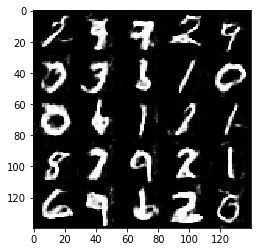

Epoch 2/2... Discriminator Loss: 1.3720... Generator Loss: 0.6929
Epoch 2/2... Discriminator Loss: 1.2875... Generator Loss: 1.1618
Epoch 2/2... Discriminator Loss: 1.2946... Generator Loss: 0.8303
Epoch 2/2... Discriminator Loss: 1.4782... Generator Loss: 0.9509
Epoch 2/2... Discriminator Loss: 1.3649... Generator Loss: 0.7570
Epoch 2/2... Discriminator Loss: 1.2395... Generator Loss: 1.1122
Epoch 2/2... Discriminator Loss: 1.3322... Generator Loss: 1.0741
Epoch 2/2... Discriminator Loss: 1.2952... Generator Loss: 1.1078
Epoch 2/2... Discriminator Loss: 1.2970... Generator Loss: 1.5235
Epoch 2/2... Discriminator Loss: 1.1801... Generator Loss: 1.0407


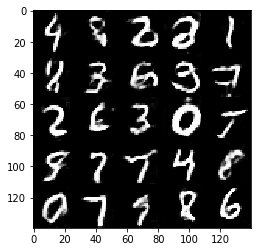

Epoch 2/2... Discriminator Loss: 1.3009... Generator Loss: 0.9368
Epoch 2/2... Discriminator Loss: 1.0777... Generator Loss: 1.0307
Epoch 2/2... Discriminator Loss: 1.2346... Generator Loss: 0.7929
Epoch 2/2... Discriminator Loss: 1.1655... Generator Loss: 1.1820
Epoch 2/2... Discriminator Loss: 1.2720... Generator Loss: 0.8540
Epoch 2/2... Discriminator Loss: 1.1400... Generator Loss: 1.0037
Epoch 2/2... Discriminator Loss: 1.2509... Generator Loss: 1.0591
Epoch 2/2... Discriminator Loss: 1.1444... Generator Loss: 1.0217
Epoch 2/2... Discriminator Loss: 1.1781... Generator Loss: 0.8881
Epoch 2/2... Discriminator Loss: 1.1848... Generator Loss: 1.1233


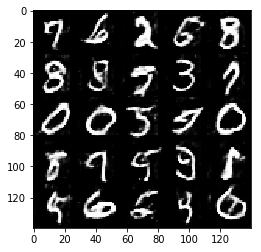

Epoch 2/2... Discriminator Loss: 1.1942... Generator Loss: 0.8726
Epoch 2/2... Discriminator Loss: 1.3412... Generator Loss: 0.7847
Epoch 2/2... Discriminator Loss: 1.1918... Generator Loss: 0.9331
Epoch 2/2... Discriminator Loss: 1.2406... Generator Loss: 1.0265
Epoch 2/2... Discriminator Loss: 1.2903... Generator Loss: 0.9333
Epoch 2/2... Discriminator Loss: 1.2031... Generator Loss: 1.0321
Epoch 2/2... Discriminator Loss: 1.2656... Generator Loss: 0.8791
Epoch 2/2... Discriminator Loss: 1.1361... Generator Loss: 0.9602
Epoch 2/2... Discriminator Loss: 1.2132... Generator Loss: 0.8671
Epoch 2/2... Discriminator Loss: 1.3646... Generator Loss: 1.0482


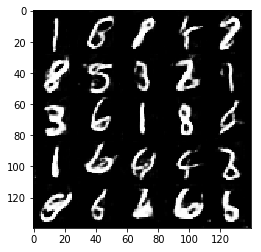

Epoch 2/2... Discriminator Loss: 1.1707... Generator Loss: 0.9846
Epoch 2/2... Discriminator Loss: 1.2216... Generator Loss: 1.1836
Epoch 2/2... Discriminator Loss: 1.2174... Generator Loss: 1.2132
Epoch 2/2... Discriminator Loss: 1.0880... Generator Loss: 1.0473
Epoch 2/2... Discriminator Loss: 1.0693... Generator Loss: 0.8526
Epoch 2/2... Discriminator Loss: 1.2733... Generator Loss: 0.7624
Epoch 2/2... Discriminator Loss: 1.2060... Generator Loss: 0.8607
Epoch 2/2... Discriminator Loss: 1.2469... Generator Loss: 0.8853
Epoch 2/2... Discriminator Loss: 1.1416... Generator Loss: 0.9969
Epoch 2/2... Discriminator Loss: 1.2173... Generator Loss: 0.9602


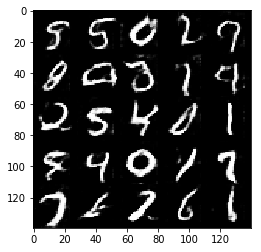

Epoch 2/2... Discriminator Loss: 1.4904... Generator Loss: 0.6505
Epoch 2/2... Discriminator Loss: 1.1130... Generator Loss: 1.0707
Epoch 2/2... Discriminator Loss: 1.1797... Generator Loss: 1.1109
Epoch 2/2... Discriminator Loss: 1.3190... Generator Loss: 0.9312
Epoch 2/2... Discriminator Loss: 1.3041... Generator Loss: 0.9800
Epoch 2/2... Discriminator Loss: 1.1091... Generator Loss: 1.0598
Epoch 2/2... Discriminator Loss: 1.1556... Generator Loss: 0.9840
Epoch 2/2... Discriminator Loss: 1.3056... Generator Loss: 0.8308
Epoch 2/2... Discriminator Loss: 1.3783... Generator Loss: 0.8376
Epoch 2/2... Discriminator Loss: 1.1630... Generator Loss: 0.6436


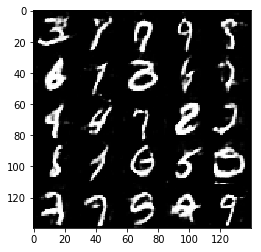

Epoch 2/2... Discriminator Loss: 1.1242... Generator Loss: 1.0362
Epoch 2/2... Discriminator Loss: 1.4121... Generator Loss: 0.6996
Epoch 2/2... Discriminator Loss: 1.1600... Generator Loss: 0.8079
Epoch 2/2... Discriminator Loss: 1.1737... Generator Loss: 0.9437
Epoch 2/2... Discriminator Loss: 1.3332... Generator Loss: 0.6960
Epoch 2/2... Discriminator Loss: 1.1034... Generator Loss: 1.1926
Epoch 2/2... Discriminator Loss: 1.1487... Generator Loss: 1.2508
Epoch 2/2... Discriminator Loss: 1.3214... Generator Loss: 1.2545
Epoch 2/2... Discriminator Loss: 1.1098... Generator Loss: 1.2336
Epoch 2/2... Discriminator Loss: 1.0775... Generator Loss: 1.0072


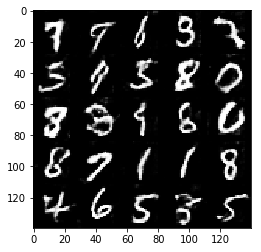

Epoch 2/2... Discriminator Loss: 1.2196... Generator Loss: 0.6800
Epoch 2/2... Discriminator Loss: 1.2002... Generator Loss: 0.7110
Epoch 2/2... Discriminator Loss: 1.3204... Generator Loss: 0.8325
Epoch 2/2... Discriminator Loss: 1.1791... Generator Loss: 1.4619
Epoch 2/2... Discriminator Loss: 1.2294... Generator Loss: 0.6773
Epoch 2/2... Discriminator Loss: 1.2192... Generator Loss: 1.1405
Epoch 2/2... Discriminator Loss: 1.4721... Generator Loss: 0.7203
Epoch 2/2... Discriminator Loss: 1.3053... Generator Loss: 1.1018
Epoch 2/2... Discriminator Loss: 1.2208... Generator Loss: 0.9316
Epoch 2/2... Discriminator Loss: 1.1478... Generator Loss: 0.9853


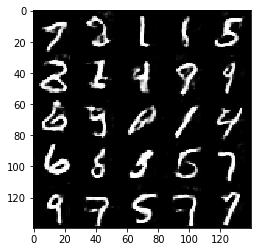

Epoch 2/2... Discriminator Loss: 1.2661... Generator Loss: 1.0916
Epoch 2/2... Discriminator Loss: 1.2743... Generator Loss: 1.2863
Epoch 2/2... Discriminator Loss: 1.1742... Generator Loss: 0.6787
Epoch 2/2... Discriminator Loss: 1.1197... Generator Loss: 0.8335
Epoch 2/2... Discriminator Loss: 1.1736... Generator Loss: 1.1934
Epoch 2/2... Discriminator Loss: 1.3815... Generator Loss: 0.8940
Epoch 2/2... Discriminator Loss: 1.1643... Generator Loss: 1.1780
Epoch 2/2... Discriminator Loss: 1.2096... Generator Loss: 1.1337
Epoch 2/2... Discriminator Loss: 1.3117... Generator Loss: 1.0575
Epoch 2/2... Discriminator Loss: 1.3026... Generator Loss: 1.2933


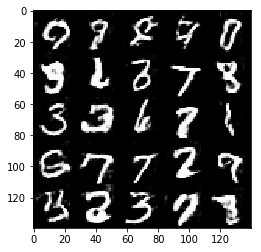

Epoch 2/2... Discriminator Loss: 1.2360... Generator Loss: 1.1029
Epoch 2/2... Discriminator Loss: 0.9992... Generator Loss: 1.0171
Epoch 2/2... Discriminator Loss: 1.2576... Generator Loss: 0.6870
Epoch 2/2... Discriminator Loss: 1.0979... Generator Loss: 1.0773
Epoch 2/2... Discriminator Loss: 1.1646... Generator Loss: 0.9502
Epoch 2/2... Discriminator Loss: 1.3007... Generator Loss: 1.1989
Epoch 2/2... Discriminator Loss: 1.2363... Generator Loss: 0.7687
Epoch 2/2... Discriminator Loss: 1.2649... Generator Loss: 1.4296
Epoch 2/2... Discriminator Loss: 1.0063... Generator Loss: 1.1271
Epoch 2/2... Discriminator Loss: 1.3968... Generator Loss: 1.2704


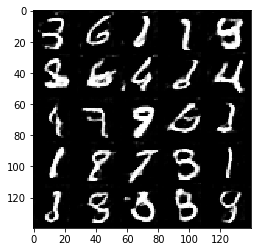

Epoch 2/2... Discriminator Loss: 1.1272... Generator Loss: 1.0482
Epoch 2/2... Discriminator Loss: 1.0942... Generator Loss: 1.0851
Epoch 2/2... Discriminator Loss: 0.9817... Generator Loss: 1.0038
Epoch 2/2... Discriminator Loss: 1.1997... Generator Loss: 0.7550
Epoch 2/2... Discriminator Loss: 1.1910... Generator Loss: 0.9002
Epoch 2/2... Discriminator Loss: 1.2822... Generator Loss: 1.0576
Epoch 2/2... Discriminator Loss: 1.3345... Generator Loss: 0.7236
Epoch 2/2... Discriminator Loss: 0.9875... Generator Loss: 1.2765
Epoch 2/2... Discriminator Loss: 1.0833... Generator Loss: 1.4000
Epoch 2/2... Discriminator Loss: 1.1984... Generator Loss: 1.0194


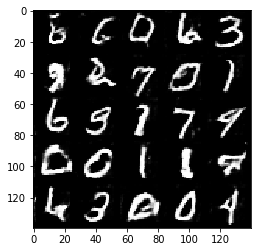

Epoch 2/2... Discriminator Loss: 1.0925... Generator Loss: 1.1624
Epoch 2/2... Discriminator Loss: 1.1344... Generator Loss: 1.2554
Epoch 2/2... Discriminator Loss: 1.4074... Generator Loss: 0.7229
Epoch 2/2... Discriminator Loss: 1.1561... Generator Loss: 1.1486
Epoch 2/2... Discriminator Loss: 1.0900... Generator Loss: 1.3368
Epoch 2/2... Discriminator Loss: 1.2082... Generator Loss: 1.2606
Epoch 2/2... Discriminator Loss: 1.2110... Generator Loss: 1.1262
Epoch 2/2... Discriminator Loss: 1.2263... Generator Loss: 1.2798
Epoch 2/2... Discriminator Loss: 1.1434... Generator Loss: 1.1385
Epoch 2/2... Discriminator Loss: 1.2176... Generator Loss: 0.7908


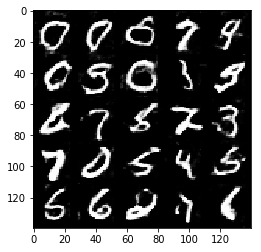

Epoch 2/2... Discriminator Loss: 1.0917... Generator Loss: 1.2247
Epoch 2/2... Discriminator Loss: 1.2455... Generator Loss: 0.8606
Epoch 2/2... Discriminator Loss: 1.2836... Generator Loss: 0.9928
Epoch 2/2... Discriminator Loss: 1.0537... Generator Loss: 1.2217
Epoch 2/2... Discriminator Loss: 1.0787... Generator Loss: 1.3538
Epoch 2/2... Discriminator Loss: 0.9486... Generator Loss: 0.9618
Epoch 2/2... Discriminator Loss: 1.2671... Generator Loss: 0.8222
Epoch 2/2... Discriminator Loss: 1.0241... Generator Loss: 0.8019
Epoch 2/2... Discriminator Loss: 1.1768... Generator Loss: 1.4282
Epoch 2/2... Discriminator Loss: 1.0471... Generator Loss: 1.1461


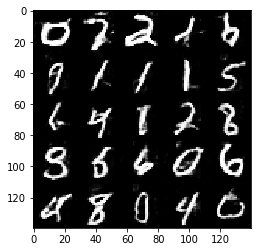

Epoch 2/2... Discriminator Loss: 1.1523... Generator Loss: 1.2804
Epoch 2/2... Discriminator Loss: 1.1724... Generator Loss: 0.8211
Epoch 2/2... Discriminator Loss: 1.3332... Generator Loss: 0.8520
Epoch 2/2... Discriminator Loss: 1.0435... Generator Loss: 1.1457
Epoch 2/2... Discriminator Loss: 1.0629... Generator Loss: 1.1531


IndexError: list index out of range

In [15]:
batch_size = 32
z_dim = 50
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/3... Discriminator Loss: 1.1637... Generator Loss: 1.2934
Epoch 1/3... Discriminator Loss: 1.1757... Generator Loss: 1.9367
Epoch 1/3... Discriminator Loss: 1.1666... Generator Loss: 0.9756
Epoch 1/3... Discriminator Loss: 0.7955... Generator Loss: 2.1129
Epoch 1/3... Discriminator Loss: 1.0909... Generator Loss: 1.2886
Epoch 1/3... Discriminator Loss: 1.1466... Generator Loss: 1.2724
Epoch 1/3... Discriminator Loss: 1.0146... Generator Loss: 1.0489
Epoch 1/3... Discriminator Loss: 1.5745... Generator Loss: 0.9514
Epoch 1/3... Discriminator Loss: 1.5117... Generator Loss: 0.6160
Epoch 1/3... Discriminator Loss: 0.9621... Generator Loss: 2.9199


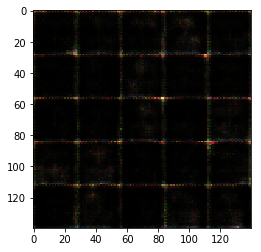

Epoch 1/3... Discriminator Loss: 1.0233... Generator Loss: 1.1635
Epoch 1/3... Discriminator Loss: 1.2275... Generator Loss: 1.0578
Epoch 1/3... Discriminator Loss: 1.4067... Generator Loss: 0.7049
Epoch 1/3... Discriminator Loss: 0.9997... Generator Loss: 1.1302
Epoch 1/3... Discriminator Loss: 1.1033... Generator Loss: 1.1361
Epoch 1/3... Discriminator Loss: 1.0275... Generator Loss: 1.0989
Epoch 1/3... Discriminator Loss: 1.4811... Generator Loss: 0.5342
Epoch 1/3... Discriminator Loss: 1.1212... Generator Loss: 1.5443
Epoch 1/3... Discriminator Loss: 1.2298... Generator Loss: 0.9790
Epoch 1/3... Discriminator Loss: 1.2494... Generator Loss: 0.7420


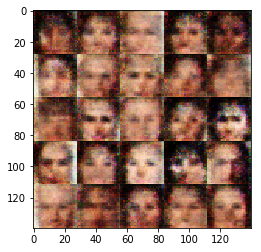

Epoch 1/3... Discriminator Loss: 1.7786... Generator Loss: 0.4744
Epoch 1/3... Discriminator Loss: 1.4163... Generator Loss: 1.2794
Epoch 1/3... Discriminator Loss: 1.1302... Generator Loss: 1.3889
Epoch 1/3... Discriminator Loss: 1.4754... Generator Loss: 0.8732
Epoch 1/3... Discriminator Loss: 1.7441... Generator Loss: 0.8309
Epoch 1/3... Discriminator Loss: 1.4302... Generator Loss: 0.9244
Epoch 1/3... Discriminator Loss: 1.7534... Generator Loss: 1.1086
Epoch 1/3... Discriminator Loss: 1.3818... Generator Loss: 0.7021
Epoch 1/3... Discriminator Loss: 1.3351... Generator Loss: 1.0883
Epoch 1/3... Discriminator Loss: 1.5336... Generator Loss: 0.7588


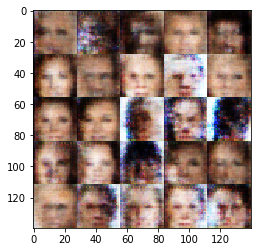

Epoch 1/3... Discriminator Loss: 1.5655... Generator Loss: 0.8697
Epoch 1/3... Discriminator Loss: 1.6597... Generator Loss: 0.9585
Epoch 1/3... Discriminator Loss: 1.7613... Generator Loss: 0.7169
Epoch 1/3... Discriminator Loss: 1.2989... Generator Loss: 1.0086
Epoch 1/3... Discriminator Loss: 1.3004... Generator Loss: 0.9923
Epoch 1/3... Discriminator Loss: 1.3315... Generator Loss: 0.7433
Epoch 1/3... Discriminator Loss: 1.2943... Generator Loss: 0.7299
Epoch 1/3... Discriminator Loss: 1.2808... Generator Loss: 1.0346
Epoch 1/3... Discriminator Loss: 1.5553... Generator Loss: 0.7552
Epoch 1/3... Discriminator Loss: 1.5599... Generator Loss: 0.7050


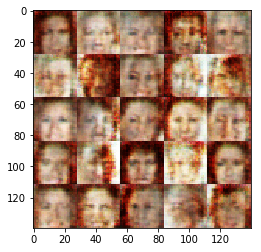

Epoch 1/3... Discriminator Loss: 1.5196... Generator Loss: 0.9646
Epoch 1/3... Discriminator Loss: 1.5928... Generator Loss: 0.7596
Epoch 1/3... Discriminator Loss: 1.5312... Generator Loss: 0.8196
Epoch 1/3... Discriminator Loss: 1.4627... Generator Loss: 0.8385
Epoch 1/3... Discriminator Loss: 1.4511... Generator Loss: 0.7525
Epoch 1/3... Discriminator Loss: 1.7339... Generator Loss: 0.7883
Epoch 1/3... Discriminator Loss: 1.5534... Generator Loss: 0.9207
Epoch 1/3... Discriminator Loss: 1.5527... Generator Loss: 0.7212
Epoch 1/3... Discriminator Loss: 1.5278... Generator Loss: 0.7790
Epoch 1/3... Discriminator Loss: 1.5732... Generator Loss: 0.6749


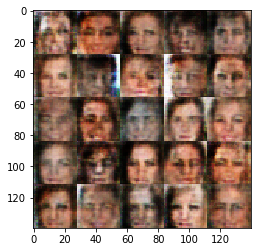

Epoch 1/3... Discriminator Loss: 1.3795... Generator Loss: 0.8384
Epoch 1/3... Discriminator Loss: 1.4162... Generator Loss: 0.9005
Epoch 1/3... Discriminator Loss: 1.2462... Generator Loss: 0.8277
Epoch 1/3... Discriminator Loss: 1.4836... Generator Loss: 0.8244
Epoch 1/3... Discriminator Loss: 1.3484... Generator Loss: 0.7080
Epoch 1/3... Discriminator Loss: 1.5995... Generator Loss: 0.9609
Epoch 1/3... Discriminator Loss: 1.4981... Generator Loss: 0.9025
Epoch 1/3... Discriminator Loss: 1.6567... Generator Loss: 0.8484
Epoch 1/3... Discriminator Loss: 1.5276... Generator Loss: 0.6344
Epoch 1/3... Discriminator Loss: 1.3641... Generator Loss: 0.7932


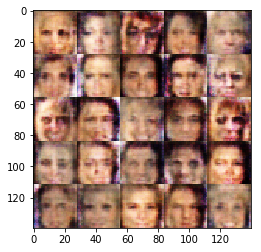

Epoch 1/3... Discriminator Loss: 1.4251... Generator Loss: 0.8981
Epoch 1/3... Discriminator Loss: 1.5111... Generator Loss: 0.7657
Epoch 1/3... Discriminator Loss: 1.4709... Generator Loss: 0.9098
Epoch 1/3... Discriminator Loss: 1.4505... Generator Loss: 0.8904
Epoch 1/3... Discriminator Loss: 1.4260... Generator Loss: 0.8682
Epoch 1/3... Discriminator Loss: 1.5136... Generator Loss: 0.7616
Epoch 1/3... Discriminator Loss: 1.4832... Generator Loss: 0.8560
Epoch 1/3... Discriminator Loss: 1.4487... Generator Loss: 0.7514
Epoch 1/3... Discriminator Loss: 1.4498... Generator Loss: 0.9226
Epoch 1/3... Discriminator Loss: 1.4361... Generator Loss: 0.8406


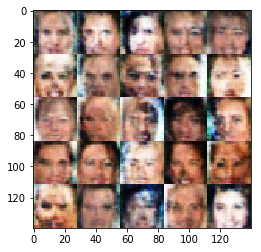

Epoch 1/3... Discriminator Loss: 1.3904... Generator Loss: 0.9118
Epoch 1/3... Discriminator Loss: 1.3860... Generator Loss: 0.8134
Epoch 1/3... Discriminator Loss: 1.5533... Generator Loss: 0.8459
Epoch 1/3... Discriminator Loss: 1.4573... Generator Loss: 0.7529
Epoch 1/3... Discriminator Loss: 1.3558... Generator Loss: 0.8383
Epoch 1/3... Discriminator Loss: 1.5311... Generator Loss: 0.7439
Epoch 1/3... Discriminator Loss: 1.4033... Generator Loss: 0.6772
Epoch 1/3... Discriminator Loss: 1.4710... Generator Loss: 0.7581
Epoch 1/3... Discriminator Loss: 1.2917... Generator Loss: 0.9115
Epoch 1/3... Discriminator Loss: 1.6082... Generator Loss: 0.7216


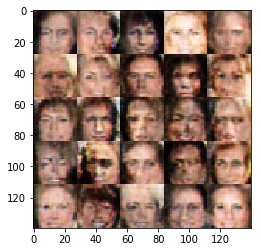

Epoch 1/3... Discriminator Loss: 1.4079... Generator Loss: 0.8662
Epoch 1/3... Discriminator Loss: 1.4398... Generator Loss: 0.6764
Epoch 1/3... Discriminator Loss: 1.4179... Generator Loss: 0.8976
Epoch 1/3... Discriminator Loss: 1.4431... Generator Loss: 0.7430
Epoch 1/3... Discriminator Loss: 1.5103... Generator Loss: 0.8521
Epoch 1/3... Discriminator Loss: 1.3682... Generator Loss: 0.7565
Epoch 1/3... Discriminator Loss: 1.4526... Generator Loss: 0.9284
Epoch 1/3... Discriminator Loss: 1.3675... Generator Loss: 0.8552
Epoch 1/3... Discriminator Loss: 1.4104... Generator Loss: 0.9692
Epoch 1/3... Discriminator Loss: 1.4227... Generator Loss: 0.8475


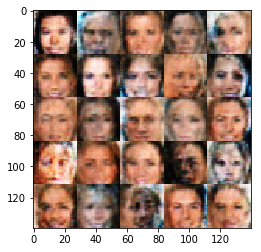

Epoch 1/3... Discriminator Loss: 1.4782... Generator Loss: 0.8733
Epoch 1/3... Discriminator Loss: 1.4358... Generator Loss: 0.7883
Epoch 1/3... Discriminator Loss: 1.3750... Generator Loss: 0.8155
Epoch 1/3... Discriminator Loss: 1.5477... Generator Loss: 0.7080
Epoch 1/3... Discriminator Loss: 1.3358... Generator Loss: 0.7714
Epoch 1/3... Discriminator Loss: 1.3434... Generator Loss: 0.9504
Epoch 1/3... Discriminator Loss: 1.4709... Generator Loss: 0.8329
Epoch 1/3... Discriminator Loss: 1.4127... Generator Loss: 0.8501
Epoch 1/3... Discriminator Loss: 1.3664... Generator Loss: 0.8593
Epoch 1/3... Discriminator Loss: 1.3634... Generator Loss: 0.8123


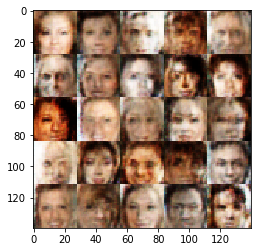

Epoch 1/3... Discriminator Loss: 1.6527... Generator Loss: 0.8709
Epoch 1/3... Discriminator Loss: 1.5111... Generator Loss: 0.7560
Epoch 1/3... Discriminator Loss: 1.3851... Generator Loss: 0.8684
Epoch 1/3... Discriminator Loss: 1.4867... Generator Loss: 0.7709
Epoch 1/3... Discriminator Loss: 1.4369... Generator Loss: 0.8545
Epoch 1/3... Discriminator Loss: 1.4168... Generator Loss: 0.7737
Epoch 1/3... Discriminator Loss: 1.4714... Generator Loss: 0.7814
Epoch 1/3... Discriminator Loss: 1.3917... Generator Loss: 0.7710
Epoch 1/3... Discriminator Loss: 1.4109... Generator Loss: 0.8458
Epoch 1/3... Discriminator Loss: 1.4631... Generator Loss: 0.7343


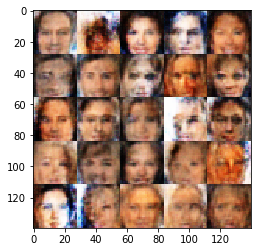

Epoch 1/3... Discriminator Loss: 1.3837... Generator Loss: 0.7200
Epoch 1/3... Discriminator Loss: 1.4500... Generator Loss: 0.7939
Epoch 1/3... Discriminator Loss: 1.4452... Generator Loss: 0.8628
Epoch 1/3... Discriminator Loss: 1.4534... Generator Loss: 0.9340
Epoch 1/3... Discriminator Loss: 1.4464... Generator Loss: 0.8269
Epoch 1/3... Discriminator Loss: 1.4527... Generator Loss: 0.8059
Epoch 1/3... Discriminator Loss: 1.3697... Generator Loss: 0.8774
Epoch 1/3... Discriminator Loss: 1.3826... Generator Loss: 0.8212
Epoch 1/3... Discriminator Loss: 1.4581... Generator Loss: 0.7521
Epoch 1/3... Discriminator Loss: 1.3181... Generator Loss: 0.8656


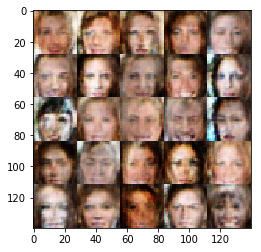

Epoch 1/3... Discriminator Loss: 1.4941... Generator Loss: 0.8583
Epoch 1/3... Discriminator Loss: 1.4211... Generator Loss: 0.8262
Epoch 1/3... Discriminator Loss: 1.4459... Generator Loss: 0.7769
Epoch 1/3... Discriminator Loss: 1.4095... Generator Loss: 0.7977
Epoch 1/3... Discriminator Loss: 1.3467... Generator Loss: 0.9339
Epoch 1/3... Discriminator Loss: 1.3538... Generator Loss: 0.7527
Epoch 1/3... Discriminator Loss: 1.3729... Generator Loss: 0.8261
Epoch 1/3... Discriminator Loss: 1.4477... Generator Loss: 0.8564
Epoch 1/3... Discriminator Loss: 1.4285... Generator Loss: 0.6958
Epoch 1/3... Discriminator Loss: 1.5150... Generator Loss: 0.7902


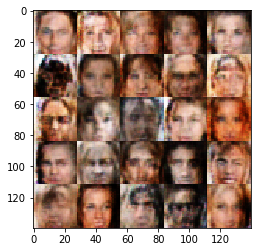

Epoch 1/3... Discriminator Loss: 1.3128... Generator Loss: 0.8966
Epoch 1/3... Discriminator Loss: 1.3886... Generator Loss: 0.9183
Epoch 1/3... Discriminator Loss: 1.4563... Generator Loss: 0.8170
Epoch 1/3... Discriminator Loss: 1.4293... Generator Loss: 0.6860
Epoch 1/3... Discriminator Loss: 1.3950... Generator Loss: 0.9267
Epoch 1/3... Discriminator Loss: 1.3551... Generator Loss: 0.8348
Epoch 1/3... Discriminator Loss: 1.5043... Generator Loss: 0.8094
Epoch 1/3... Discriminator Loss: 1.2946... Generator Loss: 0.7696
Epoch 1/3... Discriminator Loss: 1.4441... Generator Loss: 0.7304
Epoch 1/3... Discriminator Loss: 1.4017... Generator Loss: 0.7786


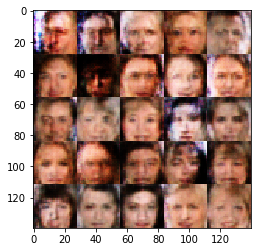

Epoch 1/3... Discriminator Loss: 1.3957... Generator Loss: 0.7892
Epoch 1/3... Discriminator Loss: 1.4539... Generator Loss: 0.8871
Epoch 1/3... Discriminator Loss: 1.4310... Generator Loss: 0.7340
Epoch 1/3... Discriminator Loss: 1.5043... Generator Loss: 0.9047
Epoch 1/3... Discriminator Loss: 1.4497... Generator Loss: 0.8270
Epoch 1/3... Discriminator Loss: 1.4575... Generator Loss: 0.7506
Epoch 1/3... Discriminator Loss: 1.4311... Generator Loss: 0.8712
Epoch 1/3... Discriminator Loss: 1.3187... Generator Loss: 0.8260
Epoch 1/3... Discriminator Loss: 1.5355... Generator Loss: 0.7883
Epoch 1/3... Discriminator Loss: 1.4823... Generator Loss: 0.8379


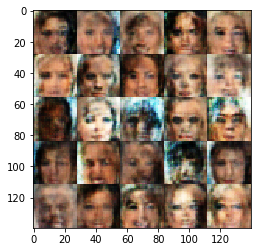

Epoch 1/3... Discriminator Loss: 1.3706... Generator Loss: 0.8994
Epoch 1/3... Discriminator Loss: 1.4429... Generator Loss: 0.8961
Epoch 1/3... Discriminator Loss: 1.3721... Generator Loss: 0.7864
Epoch 1/3... Discriminator Loss: 1.5394... Generator Loss: 0.6576
Epoch 1/3... Discriminator Loss: 1.4722... Generator Loss: 0.9072
Epoch 1/3... Discriminator Loss: 1.3290... Generator Loss: 0.8694
Epoch 1/3... Discriminator Loss: 1.4861... Generator Loss: 0.7388
Epoch 1/3... Discriminator Loss: 1.4252... Generator Loss: 0.7741
Epoch 1/3... Discriminator Loss: 1.5137... Generator Loss: 0.7229
Epoch 1/3... Discriminator Loss: 1.4288... Generator Loss: 0.7632


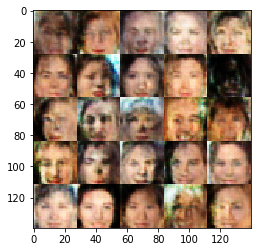

Epoch 1/3... Discriminator Loss: 1.4314... Generator Loss: 0.7139
Epoch 1/3... Discriminator Loss: 1.4870... Generator Loss: 0.8179
Epoch 1/3... Discriminator Loss: 1.4263... Generator Loss: 0.7253
Epoch 1/3... Discriminator Loss: 1.4667... Generator Loss: 0.7798
Epoch 1/3... Discriminator Loss: 1.4736... Generator Loss: 0.7021
Epoch 1/3... Discriminator Loss: 1.3617... Generator Loss: 0.8204
Epoch 1/3... Discriminator Loss: 1.4341... Generator Loss: 0.7226
Epoch 1/3... Discriminator Loss: 1.3836... Generator Loss: 0.7624
Epoch 1/3... Discriminator Loss: 1.4329... Generator Loss: 0.8168
Epoch 1/3... Discriminator Loss: 1.3804... Generator Loss: 0.6897


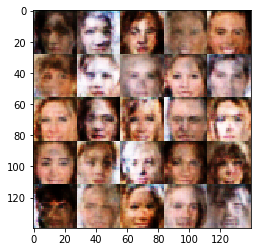

Epoch 1/3... Discriminator Loss: 1.3649... Generator Loss: 0.8593
Epoch 1/3... Discriminator Loss: 1.4283... Generator Loss: 0.7562
Epoch 1/3... Discriminator Loss: 1.4131... Generator Loss: 0.9017
Epoch 1/3... Discriminator Loss: 1.4407... Generator Loss: 0.8037
Epoch 1/3... Discriminator Loss: 1.4780... Generator Loss: 0.6885
Epoch 1/3... Discriminator Loss: 1.4813... Generator Loss: 0.7813
Epoch 1/3... Discriminator Loss: 1.3709... Generator Loss: 0.7922
Epoch 1/3... Discriminator Loss: 1.4094... Generator Loss: 0.7499
Epoch 1/3... Discriminator Loss: 1.5039... Generator Loss: 0.7863
Epoch 1/3... Discriminator Loss: 1.3493... Generator Loss: 0.9409


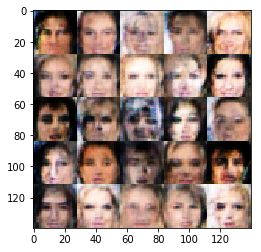

Epoch 1/3... Discriminator Loss: 1.4655... Generator Loss: 0.7701
Epoch 1/3... Discriminator Loss: 1.4649... Generator Loss: 0.8152
Epoch 1/3... Discriminator Loss: 1.4249... Generator Loss: 0.8358
Epoch 1/3... Discriminator Loss: 1.4481... Generator Loss: 0.7686
Epoch 1/3... Discriminator Loss: 1.4167... Generator Loss: 0.7472
Epoch 1/3... Discriminator Loss: 1.3453... Generator Loss: 0.8712
Epoch 1/3... Discriminator Loss: 1.4303... Generator Loss: 0.7274
Epoch 1/3... Discriminator Loss: 1.3963... Generator Loss: 0.8470
Epoch 1/3... Discriminator Loss: 1.3872... Generator Loss: 0.7957
Epoch 1/3... Discriminator Loss: 1.3877... Generator Loss: 0.7770


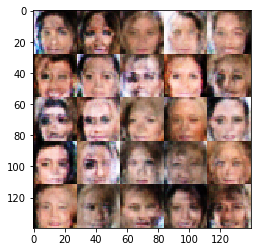

Epoch 1/3... Discriminator Loss: 1.4646... Generator Loss: 0.8702
Epoch 1/3... Discriminator Loss: 1.4691... Generator Loss: 0.8321
Epoch 1/3... Discriminator Loss: 1.4736... Generator Loss: 0.7783
Epoch 1/3... Discriminator Loss: 1.3721... Generator Loss: 0.7488
Epoch 1/3... Discriminator Loss: 1.3230... Generator Loss: 0.8593
Epoch 1/3... Discriminator Loss: 1.4116... Generator Loss: 0.8563
Epoch 1/3... Discriminator Loss: 1.4019... Generator Loss: 0.9723
Epoch 1/3... Discriminator Loss: 1.4311... Generator Loss: 0.7322
Epoch 1/3... Discriminator Loss: 1.3946... Generator Loss: 0.8716
Epoch 1/3... Discriminator Loss: 1.4751... Generator Loss: 0.7857


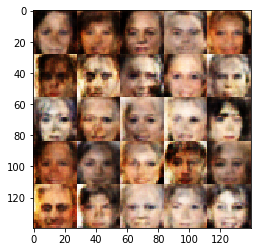

Epoch 1/3... Discriminator Loss: 1.3495... Generator Loss: 0.8110
Epoch 1/3... Discriminator Loss: 1.4914... Generator Loss: 0.8598
Epoch 1/3... Discriminator Loss: 1.4615... Generator Loss: 0.8729
Epoch 1/3... Discriminator Loss: 1.4165... Generator Loss: 0.7333
Epoch 1/3... Discriminator Loss: 1.4448... Generator Loss: 0.7533
Epoch 1/3... Discriminator Loss: 1.4400... Generator Loss: 0.8038
Epoch 1/3... Discriminator Loss: 1.3845... Generator Loss: 0.7534
Epoch 1/3... Discriminator Loss: 1.3404... Generator Loss: 0.7899
Epoch 1/3... Discriminator Loss: 1.5015... Generator Loss: 0.7633
Epoch 1/3... Discriminator Loss: 1.3643... Generator Loss: 0.7181


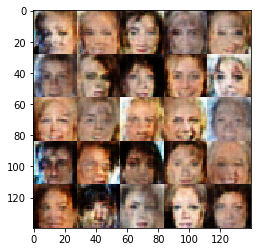

Epoch 1/3... Discriminator Loss: 1.4191... Generator Loss: 0.8261
Epoch 1/3... Discriminator Loss: 1.4389... Generator Loss: 0.7413
Epoch 1/3... Discriminator Loss: 1.4385... Generator Loss: 0.8208
Epoch 1/3... Discriminator Loss: 1.4416... Generator Loss: 0.7419
Epoch 1/3... Discriminator Loss: 1.4221... Generator Loss: 0.9079
Epoch 1/3... Discriminator Loss: 1.4253... Generator Loss: 0.7960
Epoch 1/3... Discriminator Loss: 1.4844... Generator Loss: 1.0173
Epoch 1/3... Discriminator Loss: 1.3702... Generator Loss: 0.7822
Epoch 1/3... Discriminator Loss: 1.3921... Generator Loss: 0.7383
Epoch 1/3... Discriminator Loss: 1.4983... Generator Loss: 0.8298


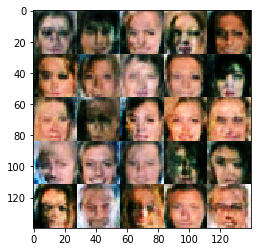

Epoch 1/3... Discriminator Loss: 1.4142... Generator Loss: 0.9032
Epoch 1/3... Discriminator Loss: 1.3514... Generator Loss: 0.8368
Epoch 1/3... Discriminator Loss: 1.4367... Generator Loss: 0.8275
Epoch 1/3... Discriminator Loss: 1.3456... Generator Loss: 0.8170
Epoch 1/3... Discriminator Loss: 1.4065... Generator Loss: 0.6894
Epoch 1/3... Discriminator Loss: 1.3987... Generator Loss: 0.7280
Epoch 1/3... Discriminator Loss: 1.3854... Generator Loss: 0.8360
Epoch 1/3... Discriminator Loss: 1.3684... Generator Loss: 0.8697
Epoch 1/3... Discriminator Loss: 1.4518... Generator Loss: 0.8058
Epoch 1/3... Discriminator Loss: 1.3510... Generator Loss: 0.7810


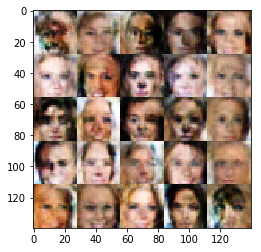

Epoch 1/3... Discriminator Loss: 1.3903... Generator Loss: 0.8659
Epoch 1/3... Discriminator Loss: 1.4058... Generator Loss: 0.8824
Epoch 1/3... Discriminator Loss: 1.4843... Generator Loss: 0.7809
Epoch 1/3... Discriminator Loss: 1.3190... Generator Loss: 0.7590
Epoch 1/3... Discriminator Loss: 1.3974... Generator Loss: 0.7702
Epoch 1/3... Discriminator Loss: 1.3886... Generator Loss: 0.8637
Epoch 1/3... Discriminator Loss: 1.4321... Generator Loss: 0.7703
Epoch 1/3... Discriminator Loss: 1.4090... Generator Loss: 0.8278
Epoch 1/3... Discriminator Loss: 1.4773... Generator Loss: 0.7781
Epoch 1/3... Discriminator Loss: 1.4536... Generator Loss: 0.8621


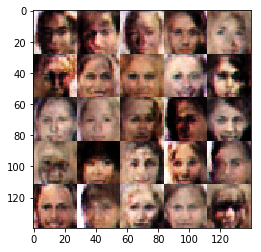

Epoch 1/3... Discriminator Loss: 1.5061... Generator Loss: 0.7423
Epoch 1/3... Discriminator Loss: 1.5054... Generator Loss: 0.7233
Epoch 1/3... Discriminator Loss: 1.4404... Generator Loss: 0.7803
Epoch 1/3... Discriminator Loss: 1.3573... Generator Loss: 0.8066
Epoch 1/3... Discriminator Loss: 1.4533... Generator Loss: 0.7319
Epoch 1/3... Discriminator Loss: 1.4036... Generator Loss: 0.8542
Epoch 1/3... Discriminator Loss: 1.4279... Generator Loss: 0.8222
Epoch 1/3... Discriminator Loss: 1.4114... Generator Loss: 0.7534
Epoch 1/3... Discriminator Loss: 1.4412... Generator Loss: 0.7889
Epoch 1/3... Discriminator Loss: 1.3988... Generator Loss: 0.8185


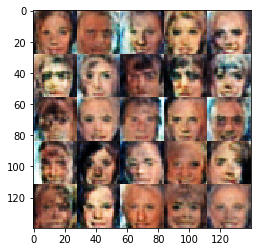

Epoch 1/3... Discriminator Loss: 1.3976... Generator Loss: 0.8839
Epoch 1/3... Discriminator Loss: 1.4011... Generator Loss: 0.8090
Epoch 1/3... Discriminator Loss: 1.4176... Generator Loss: 0.8414
Epoch 1/3... Discriminator Loss: 1.4031... Generator Loss: 0.7151
Epoch 1/3... Discriminator Loss: 1.4472... Generator Loss: 0.7800
Epoch 1/3... Discriminator Loss: 1.3964... Generator Loss: 0.7722
Epoch 1/3... Discriminator Loss: 1.4307... Generator Loss: 0.8295
Epoch 1/3... Discriminator Loss: 1.4069... Generator Loss: 0.8048
Epoch 1/3... Discriminator Loss: 1.4405... Generator Loss: 0.7890
Epoch 1/3... Discriminator Loss: 1.4019... Generator Loss: 0.8308


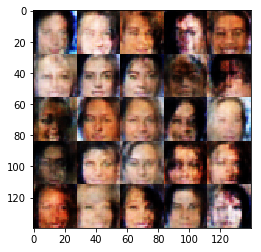

Epoch 1/3... Discriminator Loss: 1.3499... Generator Loss: 0.8651
Epoch 1/3... Discriminator Loss: 1.4324... Generator Loss: 0.8013
Epoch 1/3... Discriminator Loss: 1.4701... Generator Loss: 0.7215
Epoch 1/3... Discriminator Loss: 1.4368... Generator Loss: 0.7920
Epoch 1/3... Discriminator Loss: 1.4445... Generator Loss: 0.9129
Epoch 1/3... Discriminator Loss: 1.3970... Generator Loss: 0.7907
Epoch 1/3... Discriminator Loss: 1.3924... Generator Loss: 0.8378
Epoch 1/3... Discriminator Loss: 1.3444... Generator Loss: 0.8244
Epoch 1/3... Discriminator Loss: 1.3748... Generator Loss: 0.7616
Epoch 1/3... Discriminator Loss: 1.3597... Generator Loss: 0.6900


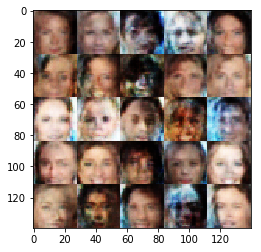

Epoch 1/3... Discriminator Loss: 1.4108... Generator Loss: 0.7666
Epoch 1/3... Discriminator Loss: 1.3583... Generator Loss: 0.8873
Epoch 1/3... Discriminator Loss: 1.4121... Generator Loss: 0.7908
Epoch 1/3... Discriminator Loss: 1.3510... Generator Loss: 0.8240
Epoch 1/3... Discriminator Loss: 1.3976... Generator Loss: 0.8657
Epoch 1/3... Discriminator Loss: 1.3985... Generator Loss: 0.7563
Epoch 1/3... Discriminator Loss: 1.4256... Generator Loss: 0.7093
Epoch 1/3... Discriminator Loss: 1.3806... Generator Loss: 0.7742
Epoch 1/3... Discriminator Loss: 1.4233... Generator Loss: 0.7517
Epoch 1/3... Discriminator Loss: 1.4589... Generator Loss: 0.7232


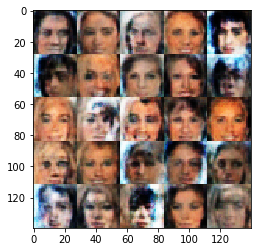

Epoch 1/3... Discriminator Loss: 1.4217... Generator Loss: 0.7039
Epoch 1/3... Discriminator Loss: 1.4080... Generator Loss: 0.7515
Epoch 1/3... Discriminator Loss: 1.4163... Generator Loss: 0.8194
Epoch 1/3... Discriminator Loss: 1.4024... Generator Loss: 0.7512
Epoch 1/3... Discriminator Loss: 1.5557... Generator Loss: 0.7377
Epoch 1/3... Discriminator Loss: 1.4678... Generator Loss: 0.7070
Epoch 1/3... Discriminator Loss: 1.5007... Generator Loss: 0.8188
Epoch 1/3... Discriminator Loss: 1.4200... Generator Loss: 0.7560
Epoch 1/3... Discriminator Loss: 1.4473... Generator Loss: 0.7310
Epoch 1/3... Discriminator Loss: 1.3963... Generator Loss: 0.7243


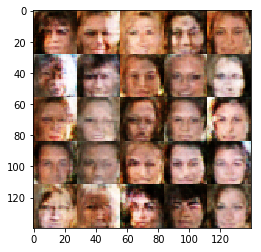

Epoch 1/3... Discriminator Loss: 1.3697... Generator Loss: 0.8915
Epoch 1/3... Discriminator Loss: 1.4483... Generator Loss: 0.7881
Epoch 1/3... Discriminator Loss: 1.3482... Generator Loss: 0.8580
Epoch 1/3... Discriminator Loss: 1.4183... Generator Loss: 0.7866
Epoch 1/3... Discriminator Loss: 1.4811... Generator Loss: 0.7508
Epoch 1/3... Discriminator Loss: 1.4336... Generator Loss: 0.7529
Epoch 1/3... Discriminator Loss: 1.3680... Generator Loss: 0.8495
Epoch 1/3... Discriminator Loss: 1.3872... Generator Loss: 0.8641
Epoch 1/3... Discriminator Loss: 1.4335... Generator Loss: 0.8138
Epoch 1/3... Discriminator Loss: 1.4836... Generator Loss: 0.6917


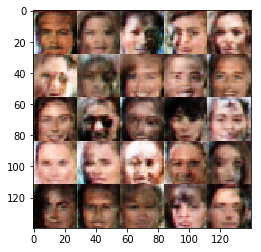

Epoch 1/3... Discriminator Loss: 1.3799... Generator Loss: 0.7414
Epoch 1/3... Discriminator Loss: 1.4027... Generator Loss: 0.8582
Epoch 1/3... Discriminator Loss: 1.4127... Generator Loss: 0.7713
Epoch 1/3... Discriminator Loss: 1.4565... Generator Loss: 0.7360
Epoch 1/3... Discriminator Loss: 1.4716... Generator Loss: 0.8604
Epoch 1/3... Discriminator Loss: 1.3967... Generator Loss: 0.7988
Epoch 1/3... Discriminator Loss: 1.3935... Generator Loss: 0.7946
Epoch 1/3... Discriminator Loss: 1.3374... Generator Loss: 0.8417
Epoch 1/3... Discriminator Loss: 1.3966... Generator Loss: 0.7961
Epoch 1/3... Discriminator Loss: 1.4597... Generator Loss: 0.7786


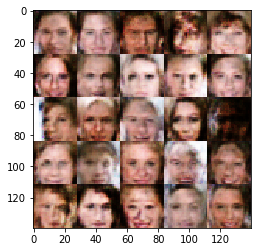

Epoch 1/3... Discriminator Loss: 1.3758... Generator Loss: 0.8544
Epoch 1/3... Discriminator Loss: 1.4103... Generator Loss: 0.7474
Epoch 1/3... Discriminator Loss: 1.4427... Generator Loss: 0.8379
Epoch 1/3... Discriminator Loss: 1.3978... Generator Loss: 0.8003
Epoch 1/3... Discriminator Loss: 1.3782... Generator Loss: 0.7760
Epoch 1/3... Discriminator Loss: 1.4275... Generator Loss: 0.8090
Epoch 1/3... Discriminator Loss: 1.3790... Generator Loss: 0.8058
Epoch 1/3... Discriminator Loss: 1.4003... Generator Loss: 0.7505
Epoch 1/3... Discriminator Loss: 1.4062... Generator Loss: 0.7086
Epoch 1/3... Discriminator Loss: 1.3663... Generator Loss: 0.7713


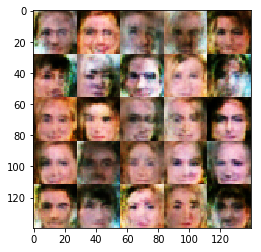

Epoch 1/3... Discriminator Loss: 1.3813... Generator Loss: 0.7947
Epoch 1/3... Discriminator Loss: 1.3991... Generator Loss: 0.8419
Epoch 1/3... Discriminator Loss: 1.4020... Generator Loss: 0.8404
Epoch 1/3... Discriminator Loss: 1.4032... Generator Loss: 0.7934
Epoch 1/3... Discriminator Loss: 1.4722... Generator Loss: 0.7177
Epoch 1/3... Discriminator Loss: 1.4901... Generator Loss: 0.7018
Epoch 1/3... Discriminator Loss: 1.3977... Generator Loss: 0.7885
Epoch 1/3... Discriminator Loss: 1.3705... Generator Loss: 0.8508
Epoch 1/3... Discriminator Loss: 1.4391... Generator Loss: 0.7911
Epoch 1/3... Discriminator Loss: 1.3866... Generator Loss: 0.7162


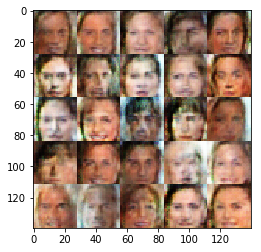

Epoch 1/3... Discriminator Loss: 1.3812... Generator Loss: 0.6742
Epoch 1/3... Discriminator Loss: 1.3896... Generator Loss: 0.7302
Epoch 1/3... Discriminator Loss: 1.4009... Generator Loss: 0.7954
Epoch 1/3... Discriminator Loss: 1.4220... Generator Loss: 0.6924
Epoch 1/3... Discriminator Loss: 1.4015... Generator Loss: 0.7748
Epoch 1/3... Discriminator Loss: 1.4293... Generator Loss: 0.7481
Epoch 1/3... Discriminator Loss: 1.4336... Generator Loss: 0.7224
Epoch 1/3... Discriminator Loss: 1.4776... Generator Loss: 0.7994
Epoch 1/3... Discriminator Loss: 1.4751... Generator Loss: 0.7017
Epoch 1/3... Discriminator Loss: 1.3715... Generator Loss: 0.7590


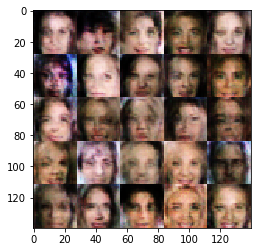

Epoch 1/3... Discriminator Loss: 1.4520... Generator Loss: 0.7522
Epoch 1/3... Discriminator Loss: 1.3822... Generator Loss: 0.8245
Epoch 1/3... Discriminator Loss: 1.3906... Generator Loss: 0.8467
Epoch 1/3... Discriminator Loss: 1.3315... Generator Loss: 0.8240
Epoch 1/3... Discriminator Loss: 1.4050... Generator Loss: 0.7672
Epoch 1/3... Discriminator Loss: 1.3944... Generator Loss: 0.7848
Epoch 1/3... Discriminator Loss: 1.4542... Generator Loss: 0.7970
Epoch 1/3... Discriminator Loss: 1.4065... Generator Loss: 0.7817
Epoch 1/3... Discriminator Loss: 1.4176... Generator Loss: 0.7536
Epoch 1/3... Discriminator Loss: 1.4015... Generator Loss: 0.7425


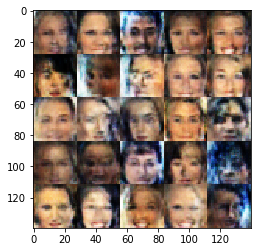

Epoch 1/3... Discriminator Loss: 1.4132... Generator Loss: 0.7279
Epoch 1/3... Discriminator Loss: 1.4139... Generator Loss: 0.7961
Epoch 1/3... Discriminator Loss: 1.3956... Generator Loss: 0.8070
Epoch 1/3... Discriminator Loss: 1.4259... Generator Loss: 0.7380
Epoch 1/3... Discriminator Loss: 1.3439... Generator Loss: 0.7965
Epoch 1/3... Discriminator Loss: 1.4809... Generator Loss: 0.7353
Epoch 1/3... Discriminator Loss: 1.3698... Generator Loss: 0.7938
Epoch 1/3... Discriminator Loss: 1.3943... Generator Loss: 0.7288
Epoch 1/3... Discriminator Loss: 1.4089... Generator Loss: 0.8013
Epoch 1/3... Discriminator Loss: 1.3574... Generator Loss: 0.8458


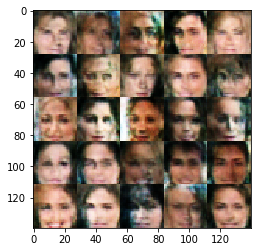

Epoch 1/3... Discriminator Loss: 1.3771... Generator Loss: 0.7295
Epoch 1/3... Discriminator Loss: 1.3675... Generator Loss: 0.7674
Epoch 1/3... Discriminator Loss: 1.4070... Generator Loss: 0.8118
Epoch 1/3... Discriminator Loss: 1.4088... Generator Loss: 0.8052
Epoch 1/3... Discriminator Loss: 1.4309... Generator Loss: 0.6968
Epoch 1/3... Discriminator Loss: 1.4267... Generator Loss: 0.7413
Epoch 1/3... Discriminator Loss: 1.3928... Generator Loss: 0.7242
Epoch 1/3... Discriminator Loss: 1.3994... Generator Loss: 0.7954
Epoch 1/3... Discriminator Loss: 1.3706... Generator Loss: 0.7215
Epoch 1/3... Discriminator Loss: 1.3770... Generator Loss: 0.8039


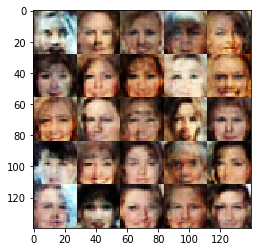

Epoch 1/3... Discriminator Loss: 1.3937... Generator Loss: 0.7929
Epoch 1/3... Discriminator Loss: 1.4693... Generator Loss: 0.7470
Epoch 1/3... Discriminator Loss: 1.3715... Generator Loss: 0.7833
Epoch 1/3... Discriminator Loss: 1.4199... Generator Loss: 0.8235
Epoch 1/3... Discriminator Loss: 1.4448... Generator Loss: 0.7828
Epoch 1/3... Discriminator Loss: 1.3843... Generator Loss: 0.7913
Epoch 1/3... Discriminator Loss: 1.5198... Generator Loss: 0.7165
Epoch 1/3... Discriminator Loss: 1.4071... Generator Loss: 0.6939
Epoch 1/3... Discriminator Loss: 1.4148... Generator Loss: 0.7502
Epoch 1/3... Discriminator Loss: 1.3348... Generator Loss: 0.8197


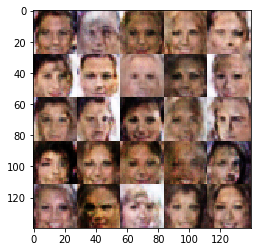

Epoch 1/3... Discriminator Loss: 1.4959... Generator Loss: 0.8387
Epoch 1/3... Discriminator Loss: 1.4584... Generator Loss: 0.7617
Epoch 1/3... Discriminator Loss: 1.3934... Generator Loss: 0.7261
Epoch 1/3... Discriminator Loss: 1.4126... Generator Loss: 0.7421
Epoch 1/3... Discriminator Loss: 1.3319... Generator Loss: 0.7295
Epoch 1/3... Discriminator Loss: 1.3811... Generator Loss: 0.8574
Epoch 1/3... Discriminator Loss: 1.4085... Generator Loss: 0.7744
Epoch 1/3... Discriminator Loss: 1.4165... Generator Loss: 0.7905
Epoch 1/3... Discriminator Loss: 1.3542... Generator Loss: 0.7199
Epoch 1/3... Discriminator Loss: 1.3898... Generator Loss: 0.7960


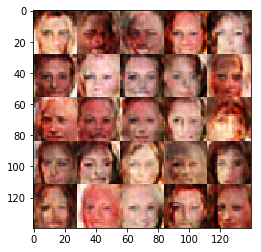

Epoch 1/3... Discriminator Loss: 1.4345... Generator Loss: 0.7911
Epoch 1/3... Discriminator Loss: 1.3807... Generator Loss: 0.7921
Epoch 1/3... Discriminator Loss: 1.4379... Generator Loss: 0.7737
Epoch 1/3... Discriminator Loss: 1.3687... Generator Loss: 0.8031
Epoch 1/3... Discriminator Loss: 1.4235... Generator Loss: 0.8291
Epoch 1/3... Discriminator Loss: 1.4029... Generator Loss: 0.8329
Epoch 1/3... Discriminator Loss: 1.3710... Generator Loss: 0.8034
Epoch 1/3... Discriminator Loss: 1.3920... Generator Loss: 0.8044
Epoch 1/3... Discriminator Loss: 1.3849... Generator Loss: 0.8004
Epoch 1/3... Discriminator Loss: 1.3468... Generator Loss: 0.7614


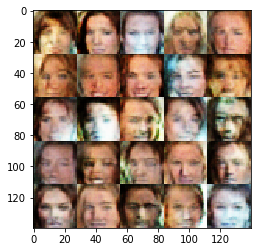

Epoch 1/3... Discriminator Loss: 1.4789... Generator Loss: 0.7724
Epoch 1/3... Discriminator Loss: 1.4409... Generator Loss: 0.7810
Epoch 1/3... Discriminator Loss: 1.4035... Generator Loss: 0.8251
Epoch 1/3... Discriminator Loss: 1.4782... Generator Loss: 0.7976
Epoch 1/3... Discriminator Loss: 1.4406... Generator Loss: 0.8976
Epoch 1/3... Discriminator Loss: 1.4121... Generator Loss: 0.7920
Epoch 1/3... Discriminator Loss: 1.3872... Generator Loss: 0.7501
Epoch 1/3... Discriminator Loss: 1.3817... Generator Loss: 0.8357
Epoch 1/3... Discriminator Loss: 1.3885... Generator Loss: 0.8174
Epoch 1/3... Discriminator Loss: 1.4011... Generator Loss: 0.7455


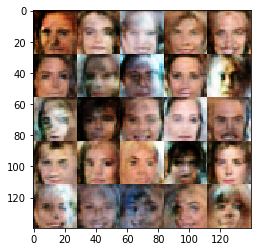

Epoch 1/3... Discriminator Loss: 1.3654... Generator Loss: 0.7784
Epoch 1/3... Discriminator Loss: 1.3762... Generator Loss: 0.8333
Epoch 1/3... Discriminator Loss: 1.4269... Generator Loss: 0.6680
Epoch 1/3... Discriminator Loss: 1.4023... Generator Loss: 0.7792
Epoch 1/3... Discriminator Loss: 1.3876... Generator Loss: 0.8601
Epoch 1/3... Discriminator Loss: 1.3686... Generator Loss: 0.8155
Epoch 1/3... Discriminator Loss: 1.3532... Generator Loss: 0.8149
Epoch 1/3... Discriminator Loss: 1.4249... Generator Loss: 0.8918
Epoch 1/3... Discriminator Loss: 1.3544... Generator Loss: 0.7860
Epoch 1/3... Discriminator Loss: 1.4077... Generator Loss: 0.7557


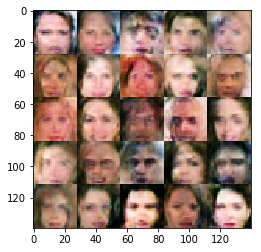

Epoch 1/3... Discriminator Loss: 1.3957... Generator Loss: 0.7068
Epoch 1/3... Discriminator Loss: 1.4019... Generator Loss: 0.7407
Epoch 1/3... Discriminator Loss: 1.4328... Generator Loss: 0.8116
Epoch 1/3... Discriminator Loss: 1.4602... Generator Loss: 0.8283
Epoch 1/3... Discriminator Loss: 1.3923... Generator Loss: 0.7791
Epoch 1/3... Discriminator Loss: 1.3886... Generator Loss: 0.7444
Epoch 1/3... Discriminator Loss: 1.4102... Generator Loss: 0.8038
Epoch 1/3... Discriminator Loss: 1.3578... Generator Loss: 0.8000
Epoch 1/3... Discriminator Loss: 1.4407... Generator Loss: 0.6686
Epoch 1/3... Discriminator Loss: 1.4276... Generator Loss: 0.8354


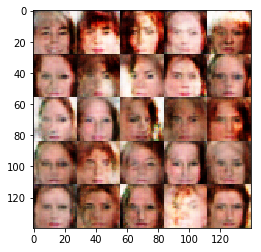

Epoch 1/3... Discriminator Loss: 1.4122... Generator Loss: 0.7861
Epoch 1/3... Discriminator Loss: 1.4289... Generator Loss: 0.7862
Epoch 1/3... Discriminator Loss: 1.3509... Generator Loss: 0.8484
Epoch 1/3... Discriminator Loss: 1.3391... Generator Loss: 0.8085
Epoch 1/3... Discriminator Loss: 1.4123... Generator Loss: 0.7206
Epoch 1/3... Discriminator Loss: 1.4101... Generator Loss: 0.7390
Epoch 1/3... Discriminator Loss: 1.4596... Generator Loss: 0.7860
Epoch 1/3... Discriminator Loss: 1.4226... Generator Loss: 0.7970
Epoch 1/3... Discriminator Loss: 1.3629... Generator Loss: 0.7647
Epoch 1/3... Discriminator Loss: 1.4056... Generator Loss: 0.7134


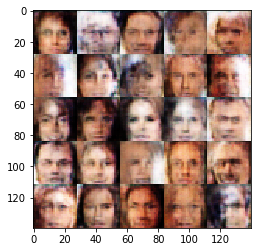

Epoch 1/3... Discriminator Loss: 1.3788... Generator Loss: 0.7354
Epoch 1/3... Discriminator Loss: 1.3905... Generator Loss: 0.7734
Epoch 1/3... Discriminator Loss: 1.3493... Generator Loss: 0.8521
Epoch 1/3... Discriminator Loss: 1.3754... Generator Loss: 0.8369
Epoch 1/3... Discriminator Loss: 1.4264... Generator Loss: 0.7793
Epoch 1/3... Discriminator Loss: 1.4479... Generator Loss: 0.7533
Epoch 1/3... Discriminator Loss: 1.4055... Generator Loss: 0.8634
Epoch 1/3... Discriminator Loss: 1.4019... Generator Loss: 0.8192
Epoch 1/3... Discriminator Loss: 1.4129... Generator Loss: 0.8676
Epoch 1/3... Discriminator Loss: 1.3977... Generator Loss: 0.7150


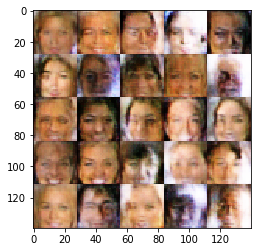

Epoch 1/3... Discriminator Loss: 1.4259... Generator Loss: 1.0125
Epoch 1/3... Discriminator Loss: 1.3880... Generator Loss: 0.8127
Epoch 1/3... Discriminator Loss: 1.4246... Generator Loss: 0.7833
Epoch 1/3... Discriminator Loss: 1.3800... Generator Loss: 0.8263
Epoch 1/3... Discriminator Loss: 1.3840... Generator Loss: 0.8562
Epoch 1/3... Discriminator Loss: 1.3808... Generator Loss: 0.8632
Epoch 1/3... Discriminator Loss: 1.3584... Generator Loss: 0.8875
Epoch 1/3... Discriminator Loss: 1.4292... Generator Loss: 0.8015
Epoch 1/3... Discriminator Loss: 1.5018... Generator Loss: 0.7196
Epoch 1/3... Discriminator Loss: 1.4212... Generator Loss: 0.7393


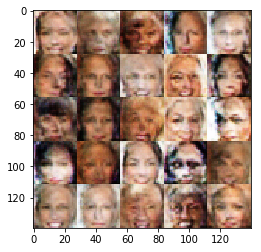

Epoch 1/3... Discriminator Loss: 1.4596... Generator Loss: 0.7319
Epoch 1/3... Discriminator Loss: 1.4375... Generator Loss: 0.7581
Epoch 1/3... Discriminator Loss: 1.3512... Generator Loss: 0.7771
Epoch 1/3... Discriminator Loss: 1.4183... Generator Loss: 0.7541
Epoch 1/3... Discriminator Loss: 1.3950... Generator Loss: 0.8330
Epoch 1/3... Discriminator Loss: 1.4296... Generator Loss: 0.8047
Epoch 1/3... Discriminator Loss: 1.4294... Generator Loss: 0.7349
Epoch 1/3... Discriminator Loss: 1.4097... Generator Loss: 0.6997
Epoch 1/3... Discriminator Loss: 1.4051... Generator Loss: 0.8065
Epoch 1/3... Discriminator Loss: 1.3922... Generator Loss: 0.8466


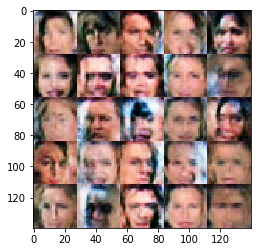

Epoch 1/3... Discriminator Loss: 1.4420... Generator Loss: 0.7372
Epoch 1/3... Discriminator Loss: 1.4162... Generator Loss: 0.7718
Epoch 1/3... Discriminator Loss: 1.4267... Generator Loss: 0.7306
Epoch 1/3... Discriminator Loss: 1.3549... Generator Loss: 0.7646
Epoch 1/3... Discriminator Loss: 1.3756... Generator Loss: 0.8498
Epoch 1/3... Discriminator Loss: 1.3973... Generator Loss: 0.8153
Epoch 1/3... Discriminator Loss: 1.4271... Generator Loss: 0.8305
Epoch 1/3... Discriminator Loss: 1.4757... Generator Loss: 0.6896
Epoch 1/3... Discriminator Loss: 1.3656... Generator Loss: 0.8040
Epoch 1/3... Discriminator Loss: 1.3567... Generator Loss: 0.7909


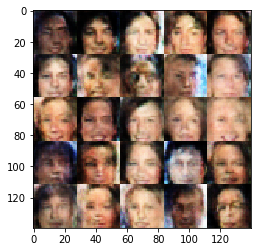

Epoch 1/3... Discriminator Loss: 1.3948... Generator Loss: 0.6893
Epoch 1/3... Discriminator Loss: 1.4537... Generator Loss: 0.8492
Epoch 1/3... Discriminator Loss: 1.4424... Generator Loss: 0.7494
Epoch 1/3... Discriminator Loss: 1.4840... Generator Loss: 0.7150
Epoch 1/3... Discriminator Loss: 1.3648... Generator Loss: 0.8716
Epoch 1/3... Discriminator Loss: 1.3933... Generator Loss: 0.8331
Epoch 1/3... Discriminator Loss: 1.4013... Generator Loss: 0.8568
Epoch 1/3... Discriminator Loss: 1.4092... Generator Loss: 0.7451
Epoch 1/3... Discriminator Loss: 1.4102... Generator Loss: 0.7681
Epoch 1/3... Discriminator Loss: 1.4062... Generator Loss: 0.7499


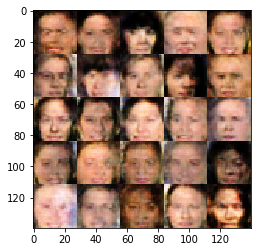

Epoch 1/3... Discriminator Loss: 1.3791... Generator Loss: 0.7915
Epoch 1/3... Discriminator Loss: 1.3897... Generator Loss: 0.7966
Epoch 1/3... Discriminator Loss: 1.4008... Generator Loss: 0.7876
Epoch 1/3... Discriminator Loss: 1.3610... Generator Loss: 0.8073
Epoch 1/3... Discriminator Loss: 1.3774... Generator Loss: 0.8137
Epoch 1/3... Discriminator Loss: 1.4075... Generator Loss: 0.8056
Epoch 1/3... Discriminator Loss: 1.3893... Generator Loss: 0.7712
Epoch 1/3... Discriminator Loss: 1.4148... Generator Loss: 0.8420
Epoch 1/3... Discriminator Loss: 1.4186... Generator Loss: 0.7607
Epoch 1/3... Discriminator Loss: 1.3656... Generator Loss: 0.8136


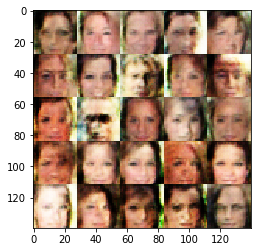

Epoch 1/3... Discriminator Loss: 1.3958... Generator Loss: 0.7987
Epoch 1/3... Discriminator Loss: 1.3990... Generator Loss: 0.8170
Epoch 1/3... Discriminator Loss: 1.3949... Generator Loss: 0.8946
Epoch 1/3... Discriminator Loss: 1.4271... Generator Loss: 0.6891
Epoch 1/3... Discriminator Loss: 1.3537... Generator Loss: 0.8238
Epoch 1/3... Discriminator Loss: 1.4181... Generator Loss: 0.8141
Epoch 1/3... Discriminator Loss: 1.3875... Generator Loss: 0.7945
Epoch 1/3... Discriminator Loss: 1.4070... Generator Loss: 0.7599
Epoch 1/3... Discriminator Loss: 1.3990... Generator Loss: 0.7713
Epoch 1/3... Discriminator Loss: 1.4078... Generator Loss: 0.7278


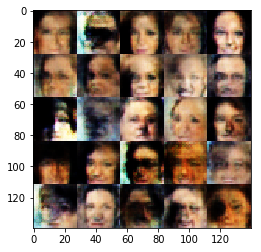

Epoch 1/3... Discriminator Loss: 1.4597... Generator Loss: 0.7346
Epoch 1/3... Discriminator Loss: 1.3903... Generator Loss: 0.8585
Epoch 1/3... Discriminator Loss: 1.3794... Generator Loss: 0.8293
Epoch 1/3... Discriminator Loss: 1.3572... Generator Loss: 0.8828
Epoch 1/3... Discriminator Loss: 1.4216... Generator Loss: 0.8373
Epoch 1/3... Discriminator Loss: 1.4254... Generator Loss: 0.6754
Epoch 1/3... Discriminator Loss: 1.4484... Generator Loss: 0.7874
Epoch 1/3... Discriminator Loss: 1.3990... Generator Loss: 0.6962
Epoch 1/3... Discriminator Loss: 1.3974... Generator Loss: 0.8058
Epoch 1/3... Discriminator Loss: 1.3788... Generator Loss: 0.8124


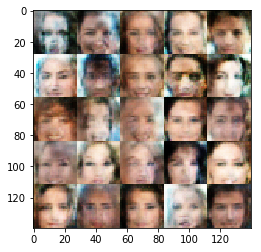

Epoch 1/3... Discriminator Loss: 1.4212... Generator Loss: 0.7300
Epoch 1/3... Discriminator Loss: 1.4201... Generator Loss: 0.8326
Epoch 1/3... Discriminator Loss: 1.3732... Generator Loss: 0.7804
Epoch 1/3... Discriminator Loss: 1.4162... Generator Loss: 0.7878
Epoch 1/3... Discriminator Loss: 1.4738... Generator Loss: 0.6748
Epoch 1/3... Discriminator Loss: 1.4394... Generator Loss: 0.6677
Epoch 1/3... Discriminator Loss: 1.4182... Generator Loss: 0.7523
Epoch 1/3... Discriminator Loss: 1.4090... Generator Loss: 0.8317
Epoch 1/3... Discriminator Loss: 1.4386... Generator Loss: 0.7164
Epoch 1/3... Discriminator Loss: 1.3681... Generator Loss: 0.8363


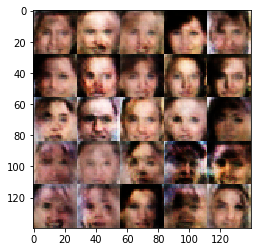

Epoch 1/3... Discriminator Loss: 1.4455... Generator Loss: 0.7802
Epoch 1/3... Discriminator Loss: 1.3856... Generator Loss: 0.8322
Epoch 1/3... Discriminator Loss: 1.3660... Generator Loss: 0.7900
Epoch 1/3... Discriminator Loss: 1.3788... Generator Loss: 0.7910
Epoch 1/3... Discriminator Loss: 1.4706... Generator Loss: 0.7665
Epoch 1/3... Discriminator Loss: 1.3449... Generator Loss: 0.9531
Epoch 1/3... Discriminator Loss: 1.3842... Generator Loss: 0.8346
Epoch 1/3... Discriminator Loss: 1.4124... Generator Loss: 0.8388
Epoch 1/3... Discriminator Loss: 1.3515... Generator Loss: 0.9075
Epoch 1/3... Discriminator Loss: 1.3832... Generator Loss: 0.7966


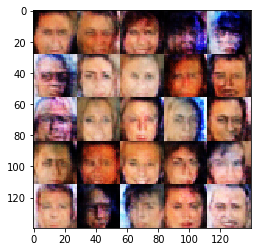

Epoch 1/3... Discriminator Loss: 1.4030... Generator Loss: 0.7054
Epoch 1/3... Discriminator Loss: 1.4326... Generator Loss: 0.7401
Epoch 1/3... Discriminator Loss: 1.3949... Generator Loss: 0.7779
Epoch 1/3... Discriminator Loss: 1.3969... Generator Loss: 0.7824
Epoch 1/3... Discriminator Loss: 1.4150... Generator Loss: 0.7146
Epoch 1/3... Discriminator Loss: 1.4115... Generator Loss: 0.8119
Epoch 1/3... Discriminator Loss: 1.4037... Generator Loss: 0.8455
Epoch 1/3... Discriminator Loss: 1.3902... Generator Loss: 0.7707
Epoch 1/3... Discriminator Loss: 1.4163... Generator Loss: 0.8556
Epoch 1/3... Discriminator Loss: 1.4085... Generator Loss: 0.7952


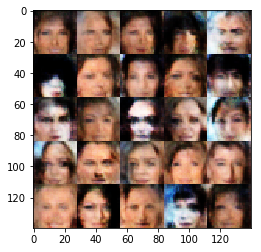

Epoch 1/3... Discriminator Loss: 1.3874... Generator Loss: 0.8105
Epoch 1/3... Discriminator Loss: 1.4119... Generator Loss: 0.7453
Epoch 1/3... Discriminator Loss: 1.3888... Generator Loss: 0.8006
Epoch 1/3... Discriminator Loss: 1.3788... Generator Loss: 0.7903
Epoch 1/3... Discriminator Loss: 1.4144... Generator Loss: 0.7206
Epoch 1/3... Discriminator Loss: 1.4334... Generator Loss: 0.8399
Epoch 1/3... Discriminator Loss: 1.3717... Generator Loss: 0.7626
Epoch 1/3... Discriminator Loss: 1.3648... Generator Loss: 0.7515
Epoch 1/3... Discriminator Loss: 1.4103... Generator Loss: 0.7777
Epoch 1/3... Discriminator Loss: 1.3873... Generator Loss: 0.7277


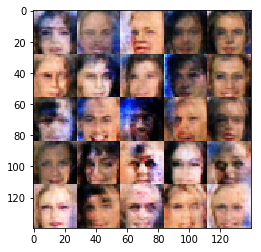

Epoch 1/3... Discriminator Loss: 1.3851... Generator Loss: 0.7656
Epoch 1/3... Discriminator Loss: 1.3650... Generator Loss: 0.8610
Epoch 1/3... Discriminator Loss: 1.3920... Generator Loss: 0.7529
Epoch 1/3... Discriminator Loss: 1.4303... Generator Loss: 0.7671
Epoch 1/3... Discriminator Loss: 1.3920... Generator Loss: 0.7127
Epoch 1/3... Discriminator Loss: 1.3975... Generator Loss: 0.7520
Epoch 1/3... Discriminator Loss: 1.4684... Generator Loss: 0.7331
Epoch 1/3... Discriminator Loss: 1.4182... Generator Loss: 0.8030
Epoch 1/3... Discriminator Loss: 1.3796... Generator Loss: 0.8465
Epoch 1/3... Discriminator Loss: 1.4077... Generator Loss: 0.7436


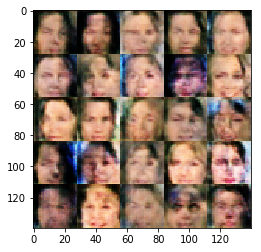

Epoch 1/3... Discriminator Loss: 1.4505... Generator Loss: 0.7021
Epoch 1/3... Discriminator Loss: 1.3592... Generator Loss: 0.7648
Epoch 1/3... Discriminator Loss: 1.4933... Generator Loss: 0.8038
Epoch 1/3... Discriminator Loss: 1.4473... Generator Loss: 0.6901
Epoch 1/3... Discriminator Loss: 1.4432... Generator Loss: 0.7677
Epoch 1/3... Discriminator Loss: 1.4284... Generator Loss: 0.8708
Epoch 1/3... Discriminator Loss: 1.4194... Generator Loss: 0.8417
Epoch 1/3... Discriminator Loss: 1.3680... Generator Loss: 0.7567
Epoch 1/3... Discriminator Loss: 1.4246... Generator Loss: 0.8487
Epoch 1/3... Discriminator Loss: 1.3550... Generator Loss: 0.7761


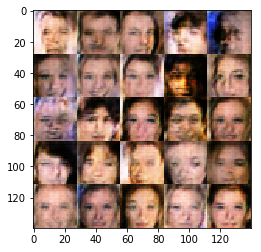

Epoch 1/3... Discriminator Loss: 1.4098... Generator Loss: 0.6817
Epoch 1/3... Discriminator Loss: 1.3822... Generator Loss: 0.7967
Epoch 1/3... Discriminator Loss: 1.4129... Generator Loss: 0.8244
Epoch 1/3... Discriminator Loss: 1.4388... Generator Loss: 0.7059
Epoch 1/3... Discriminator Loss: 1.3913... Generator Loss: 0.7165
Epoch 1/3... Discriminator Loss: 1.4120... Generator Loss: 0.8474
Epoch 1/3... Discriminator Loss: 1.4111... Generator Loss: 0.7604
Epoch 1/3... Discriminator Loss: 1.3669... Generator Loss: 0.8256
Epoch 1/3... Discriminator Loss: 1.4034... Generator Loss: 0.7777
Epoch 1/3... Discriminator Loss: 1.3878... Generator Loss: 0.7613


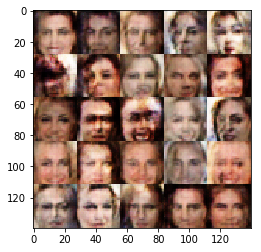

Epoch 1/3... Discriminator Loss: 1.3994... Generator Loss: 0.7873
Epoch 1/3... Discriminator Loss: 1.3895... Generator Loss: 0.7544
Epoch 1/3... Discriminator Loss: 1.3817... Generator Loss: 0.8443
Epoch 1/3... Discriminator Loss: 1.4252... Generator Loss: 0.8283
Epoch 1/3... Discriminator Loss: 1.3933... Generator Loss: 0.7606
Epoch 1/3... Discriminator Loss: 1.4015... Generator Loss: 0.7306
Epoch 1/3... Discriminator Loss: 1.4075... Generator Loss: 0.7264
Epoch 1/3... Discriminator Loss: 1.3762... Generator Loss: 0.8427
Epoch 1/3... Discriminator Loss: 1.4645... Generator Loss: 0.7530
Epoch 1/3... Discriminator Loss: 1.4413... Generator Loss: 0.7574


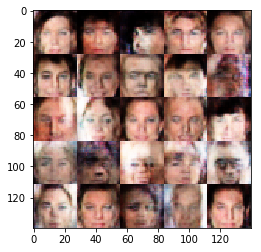

Epoch 1/3... Discriminator Loss: 1.4077... Generator Loss: 0.7738
Epoch 1/3... Discriminator Loss: 1.4298... Generator Loss: 0.7195
Epoch 1/3... Discriminator Loss: 1.4254... Generator Loss: 0.7486
Epoch 1/3... Discriminator Loss: 1.3957... Generator Loss: 0.7697
Epoch 1/3... Discriminator Loss: 1.3655... Generator Loss: 0.8319
Epoch 1/3... Discriminator Loss: 1.4045... Generator Loss: 0.7779
Epoch 1/3... Discriminator Loss: 1.4326... Generator Loss: 0.7897
Epoch 1/3... Discriminator Loss: 1.4480... Generator Loss: 0.7458
Epoch 1/3... Discriminator Loss: 1.3973... Generator Loss: 0.8132
Epoch 1/3... Discriminator Loss: 1.3885... Generator Loss: 0.7952


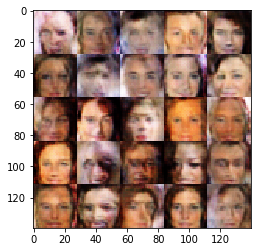

Epoch 1/3... Discriminator Loss: 1.4148... Generator Loss: 0.8895
Epoch 1/3... Discriminator Loss: 1.3965... Generator Loss: 0.7570
Epoch 1/3... Discriminator Loss: 1.3805... Generator Loss: 0.8839
Epoch 1/3... Discriminator Loss: 1.4247... Generator Loss: 0.7780
Epoch 1/3... Discriminator Loss: 1.3700... Generator Loss: 0.8312
Epoch 1/3... Discriminator Loss: 1.4342... Generator Loss: 0.8446
Epoch 1/3... Discriminator Loss: 1.3830... Generator Loss: 0.7708
Epoch 1/3... Discriminator Loss: 1.4027... Generator Loss: 0.7894
Epoch 1/3... Discriminator Loss: 1.3973... Generator Loss: 0.7856
Epoch 1/3... Discriminator Loss: 1.3395... Generator Loss: 0.7698


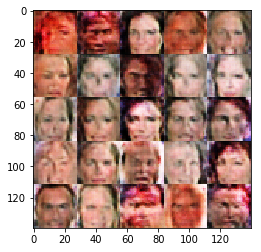

Epoch 1/3... Discriminator Loss: 1.4167... Generator Loss: 0.7922
Epoch 1/3... Discriminator Loss: 1.4107... Generator Loss: 0.8456
Epoch 1/3... Discriminator Loss: 1.4021... Generator Loss: 0.7585
Epoch 1/3... Discriminator Loss: 1.4139... Generator Loss: 0.7335
Epoch 1/3... Discriminator Loss: 1.3852... Generator Loss: 0.7429
Epoch 1/3... Discriminator Loss: 1.4253... Generator Loss: 0.7241
Epoch 1/3... Discriminator Loss: 1.3872... Generator Loss: 0.8601
Epoch 1/3... Discriminator Loss: 1.3469... Generator Loss: 0.7981
Epoch 1/3... Discriminator Loss: 1.3787... Generator Loss: 0.7863
Epoch 1/3... Discriminator Loss: 1.4032... Generator Loss: 0.7735


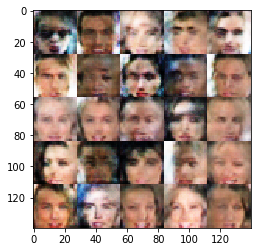

Epoch 1/3... Discriminator Loss: 1.4189... Generator Loss: 0.8196
Epoch 1/3... Discriminator Loss: 1.3562... Generator Loss: 0.7859
Epoch 1/3... Discriminator Loss: 1.3787... Generator Loss: 0.7896
Epoch 2/3... Discriminator Loss: 1.3801... Generator Loss: 0.7244
Epoch 2/3... Discriminator Loss: 1.4145... Generator Loss: 0.7871
Epoch 2/3... Discriminator Loss: 1.3623... Generator Loss: 0.8552
Epoch 2/3... Discriminator Loss: 1.3895... Generator Loss: 0.7511
Epoch 2/3... Discriminator Loss: 1.3855... Generator Loss: 0.8334
Epoch 2/3... Discriminator Loss: 1.4816... Generator Loss: 0.6645
Epoch 2/3... Discriminator Loss: 1.3620... Generator Loss: 0.7421


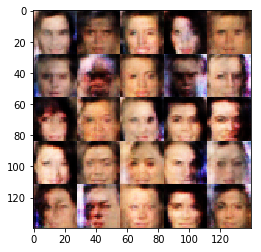

Epoch 2/3... Discriminator Loss: 1.3518... Generator Loss: 0.7182
Epoch 2/3... Discriminator Loss: 1.3907... Generator Loss: 0.7519
Epoch 2/3... Discriminator Loss: 1.4261... Generator Loss: 0.6240
Epoch 2/3... Discriminator Loss: 1.3845... Generator Loss: 0.8090
Epoch 2/3... Discriminator Loss: 1.3939... Generator Loss: 0.8812
Epoch 2/3... Discriminator Loss: 1.3787... Generator Loss: 0.8070
Epoch 2/3... Discriminator Loss: 1.3873... Generator Loss: 0.8287
Epoch 2/3... Discriminator Loss: 1.3840... Generator Loss: 0.7806
Epoch 2/3... Discriminator Loss: 1.4154... Generator Loss: 0.7879
Epoch 2/3... Discriminator Loss: 1.3636... Generator Loss: 0.8082


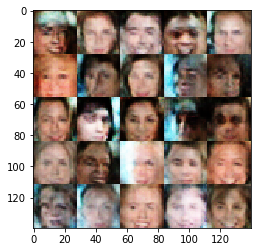

Epoch 2/3... Discriminator Loss: 1.4239... Generator Loss: 0.8013
Epoch 2/3... Discriminator Loss: 1.3644... Generator Loss: 0.8012
Epoch 2/3... Discriminator Loss: 1.4087... Generator Loss: 0.7820
Epoch 2/3... Discriminator Loss: 1.3647... Generator Loss: 0.8844
Epoch 2/3... Discriminator Loss: 1.4195... Generator Loss: 0.8314
Epoch 2/3... Discriminator Loss: 1.3722... Generator Loss: 0.8282
Epoch 2/3... Discriminator Loss: 1.3682... Generator Loss: 0.7665
Epoch 2/3... Discriminator Loss: 1.3583... Generator Loss: 0.8219
Epoch 2/3... Discriminator Loss: 1.3989... Generator Loss: 0.8254
Epoch 2/3... Discriminator Loss: 1.4141... Generator Loss: 0.8177


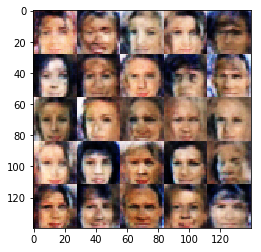

Epoch 2/3... Discriminator Loss: 1.3675... Generator Loss: 0.8098
Epoch 2/3... Discriminator Loss: 1.3735... Generator Loss: 0.8226
Epoch 2/3... Discriminator Loss: 1.3785... Generator Loss: 0.8332
Epoch 2/3... Discriminator Loss: 1.3772... Generator Loss: 0.7707
Epoch 2/3... Discriminator Loss: 1.4079... Generator Loss: 0.7900
Epoch 2/3... Discriminator Loss: 1.3733... Generator Loss: 0.8271
Epoch 2/3... Discriminator Loss: 1.3810... Generator Loss: 0.8603
Epoch 2/3... Discriminator Loss: 1.3697... Generator Loss: 0.7789
Epoch 2/3... Discriminator Loss: 1.3781... Generator Loss: 0.8129
Epoch 2/3... Discriminator Loss: 1.3688... Generator Loss: 0.8088


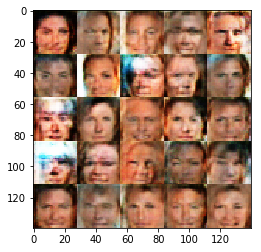

Epoch 2/3... Discriminator Loss: 1.4250... Generator Loss: 0.7902
Epoch 2/3... Discriminator Loss: 1.3961... Generator Loss: 0.7970
Epoch 2/3... Discriminator Loss: 1.3962... Generator Loss: 0.7548
Epoch 2/3... Discriminator Loss: 1.4119... Generator Loss: 0.7455
Epoch 2/3... Discriminator Loss: 1.4526... Generator Loss: 0.8251
Epoch 2/3... Discriminator Loss: 1.4169... Generator Loss: 0.7573
Epoch 2/3... Discriminator Loss: 1.4261... Generator Loss: 0.7745
Epoch 2/3... Discriminator Loss: 1.3845... Generator Loss: 0.7809
Epoch 2/3... Discriminator Loss: 1.3694... Generator Loss: 0.8085
Epoch 2/3... Discriminator Loss: 1.3798... Generator Loss: 0.7744


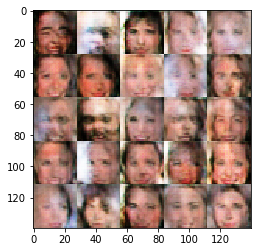

Epoch 2/3... Discriminator Loss: 1.3503... Generator Loss: 0.7938
Epoch 2/3... Discriminator Loss: 1.4027... Generator Loss: 0.8623
Epoch 2/3... Discriminator Loss: 1.4113... Generator Loss: 0.7923
Epoch 2/3... Discriminator Loss: 1.4077... Generator Loss: 0.7528
Epoch 2/3... Discriminator Loss: 1.3609... Generator Loss: 0.8530
Epoch 2/3... Discriminator Loss: 1.4237... Generator Loss: 0.7603
Epoch 2/3... Discriminator Loss: 1.4173... Generator Loss: 0.7332
Epoch 2/3... Discriminator Loss: 1.4356... Generator Loss: 0.7425
Epoch 2/3... Discriminator Loss: 1.3967... Generator Loss: 0.7596
Epoch 2/3... Discriminator Loss: 1.4209... Generator Loss: 0.6800


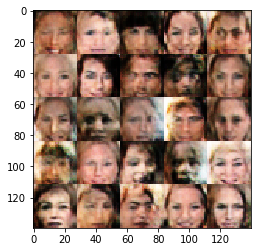

Epoch 2/3... Discriminator Loss: 1.3710... Generator Loss: 0.8123
Epoch 2/3... Discriminator Loss: 1.3648... Generator Loss: 0.7507
Epoch 2/3... Discriminator Loss: 1.4166... Generator Loss: 0.7798
Epoch 2/3... Discriminator Loss: 1.3712... Generator Loss: 0.7702
Epoch 2/3... Discriminator Loss: 1.3890... Generator Loss: 0.8238
Epoch 2/3... Discriminator Loss: 1.3929... Generator Loss: 0.7585
Epoch 2/3... Discriminator Loss: 1.3796... Generator Loss: 0.8185
Epoch 2/3... Discriminator Loss: 1.4578... Generator Loss: 0.7172
Epoch 2/3... Discriminator Loss: 1.3998... Generator Loss: 0.8397
Epoch 2/3... Discriminator Loss: 1.3768... Generator Loss: 0.7806


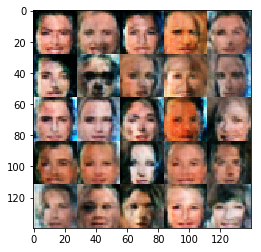

Epoch 2/3... Discriminator Loss: 1.3881... Generator Loss: 0.7395
Epoch 2/3... Discriminator Loss: 1.3842... Generator Loss: 0.7476
Epoch 2/3... Discriminator Loss: 1.3572... Generator Loss: 0.8252
Epoch 2/3... Discriminator Loss: 1.4150... Generator Loss: 0.7816
Epoch 2/3... Discriminator Loss: 1.3780... Generator Loss: 0.8053
Epoch 2/3... Discriminator Loss: 1.3773... Generator Loss: 0.8352
Epoch 2/3... Discriminator Loss: 1.3554... Generator Loss: 0.8093
Epoch 2/3... Discriminator Loss: 1.3189... Generator Loss: 0.7613
Epoch 2/3... Discriminator Loss: 1.3963... Generator Loss: 0.8549
Epoch 2/3... Discriminator Loss: 1.3750... Generator Loss: 0.7595


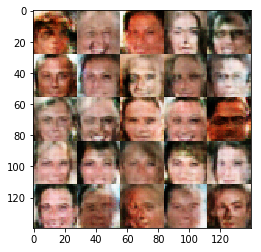

Epoch 2/3... Discriminator Loss: 1.3867... Generator Loss: 0.7319
Epoch 2/3... Discriminator Loss: 1.3649... Generator Loss: 0.8883
Epoch 2/3... Discriminator Loss: 1.3730... Generator Loss: 0.7389
Epoch 2/3... Discriminator Loss: 1.4075... Generator Loss: 0.8626
Epoch 2/3... Discriminator Loss: 1.3629... Generator Loss: 0.7751
Epoch 2/3... Discriminator Loss: 1.3932... Generator Loss: 0.7628
Epoch 2/3... Discriminator Loss: 1.3865... Generator Loss: 0.7707
Epoch 2/3... Discriminator Loss: 1.3824... Generator Loss: 0.7697
Epoch 2/3... Discriminator Loss: 1.4004... Generator Loss: 0.7435
Epoch 2/3... Discriminator Loss: 1.4079... Generator Loss: 0.8103


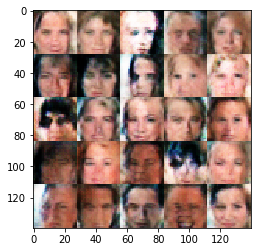

Epoch 2/3... Discriminator Loss: 1.4103... Generator Loss: 0.7762
Epoch 2/3... Discriminator Loss: 1.3853... Generator Loss: 0.7767
Epoch 2/3... Discriminator Loss: 1.3672... Generator Loss: 0.8557
Epoch 2/3... Discriminator Loss: 1.3725... Generator Loss: 0.8263
Epoch 2/3... Discriminator Loss: 1.4043... Generator Loss: 0.7780
Epoch 2/3... Discriminator Loss: 1.4666... Generator Loss: 0.7224
Epoch 2/3... Discriminator Loss: 1.3643... Generator Loss: 0.7816
Epoch 2/3... Discriminator Loss: 1.4397... Generator Loss: 0.7816
Epoch 2/3... Discriminator Loss: 1.3671... Generator Loss: 0.7517
Epoch 2/3... Discriminator Loss: 1.3681... Generator Loss: 0.7520


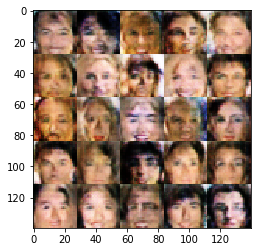

Epoch 2/3... Discriminator Loss: 1.3910... Generator Loss: 0.7964
Epoch 2/3... Discriminator Loss: 1.3564... Generator Loss: 0.8362
Epoch 2/3... Discriminator Loss: 1.3672... Generator Loss: 0.8317
Epoch 2/3... Discriminator Loss: 1.3590... Generator Loss: 0.8722
Epoch 2/3... Discriminator Loss: 1.4112... Generator Loss: 0.7608
Epoch 2/3... Discriminator Loss: 1.4271... Generator Loss: 0.7864
Epoch 2/3... Discriminator Loss: 1.3906... Generator Loss: 0.7657
Epoch 2/3... Discriminator Loss: 1.3847... Generator Loss: 0.7935
Epoch 2/3... Discriminator Loss: 1.3895... Generator Loss: 0.7500
Epoch 2/3... Discriminator Loss: 1.3972... Generator Loss: 0.8975


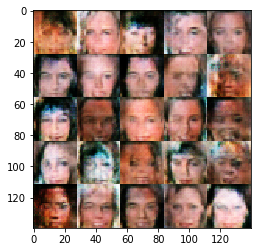

Epoch 2/3... Discriminator Loss: 1.4158... Generator Loss: 0.7514
Epoch 2/3... Discriminator Loss: 1.4038... Generator Loss: 0.8106
Epoch 2/3... Discriminator Loss: 1.4291... Generator Loss: 0.9471
Epoch 2/3... Discriminator Loss: 1.4194... Generator Loss: 0.7696
Epoch 2/3... Discriminator Loss: 1.3788... Generator Loss: 0.7975
Epoch 2/3... Discriminator Loss: 1.3842... Generator Loss: 0.9091
Epoch 2/3... Discriminator Loss: 1.3622... Generator Loss: 0.8214
Epoch 2/3... Discriminator Loss: 1.3783... Generator Loss: 0.8007
Epoch 2/3... Discriminator Loss: 1.3710... Generator Loss: 0.7760
Epoch 2/3... Discriminator Loss: 1.4499... Generator Loss: 0.7749


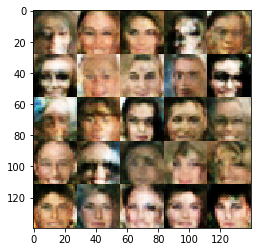

Epoch 2/3... Discriminator Loss: 1.3717... Generator Loss: 0.7398
Epoch 2/3... Discriminator Loss: 1.3756... Generator Loss: 0.8797
Epoch 2/3... Discriminator Loss: 1.4131... Generator Loss: 0.8042
Epoch 2/3... Discriminator Loss: 1.3540... Generator Loss: 0.7528
Epoch 2/3... Discriminator Loss: 1.3956... Generator Loss: 0.8464
Epoch 2/3... Discriminator Loss: 1.3902... Generator Loss: 0.7756
Epoch 2/3... Discriminator Loss: 1.3765... Generator Loss: 0.8084
Epoch 2/3... Discriminator Loss: 1.4049... Generator Loss: 0.7794
Epoch 2/3... Discriminator Loss: 1.3490... Generator Loss: 0.7579
Epoch 2/3... Discriminator Loss: 1.3775... Generator Loss: 0.8188


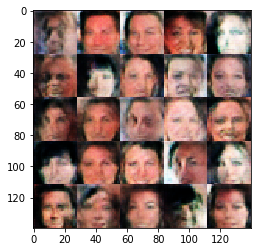

Epoch 2/3... Discriminator Loss: 1.3937... Generator Loss: 0.7717
Epoch 2/3... Discriminator Loss: 1.4090... Generator Loss: 0.7682
Epoch 2/3... Discriminator Loss: 1.3931... Generator Loss: 0.7830
Epoch 2/3... Discriminator Loss: 1.4400... Generator Loss: 0.7627
Epoch 2/3... Discriminator Loss: 1.4016... Generator Loss: 0.7339
Epoch 2/3... Discriminator Loss: 1.3993... Generator Loss: 0.7586
Epoch 2/3... Discriminator Loss: 1.3784... Generator Loss: 0.8214
Epoch 2/3... Discriminator Loss: 1.3720... Generator Loss: 0.7864
Epoch 2/3... Discriminator Loss: 1.4162... Generator Loss: 0.8131
Epoch 2/3... Discriminator Loss: 1.4060... Generator Loss: 0.7225


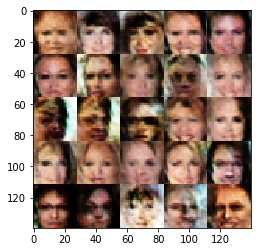

Epoch 2/3... Discriminator Loss: 1.4083... Generator Loss: 0.7421
Epoch 2/3... Discriminator Loss: 1.4135... Generator Loss: 0.8281
Epoch 2/3... Discriminator Loss: 1.4245... Generator Loss: 0.8623
Epoch 2/3... Discriminator Loss: 1.3897... Generator Loss: 0.8266
Epoch 2/3... Discriminator Loss: 1.3863... Generator Loss: 0.7944
Epoch 2/3... Discriminator Loss: 1.3865... Generator Loss: 0.7936
Epoch 2/3... Discriminator Loss: 1.3796... Generator Loss: 0.8268
Epoch 2/3... Discriminator Loss: 1.4067... Generator Loss: 0.7997
Epoch 2/3... Discriminator Loss: 1.3672... Generator Loss: 0.7697
Epoch 2/3... Discriminator Loss: 1.3994... Generator Loss: 0.8524


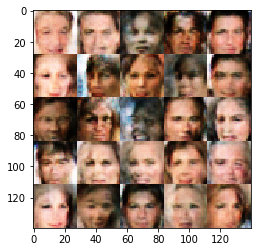

Epoch 2/3... Discriminator Loss: 1.3692... Generator Loss: 0.7749
Epoch 2/3... Discriminator Loss: 1.3551... Generator Loss: 0.7241
Epoch 2/3... Discriminator Loss: 1.3991... Generator Loss: 0.8146
Epoch 2/3... Discriminator Loss: 1.4513... Generator Loss: 0.6833
Epoch 2/3... Discriminator Loss: 1.3802... Generator Loss: 0.7730
Epoch 2/3... Discriminator Loss: 1.3504... Generator Loss: 0.8299
Epoch 2/3... Discriminator Loss: 1.3910... Generator Loss: 0.7368
Epoch 2/3... Discriminator Loss: 1.3742... Generator Loss: 0.8698
Epoch 2/3... Discriminator Loss: 1.3792... Generator Loss: 0.8202
Epoch 2/3... Discriminator Loss: 1.3913... Generator Loss: 0.7965


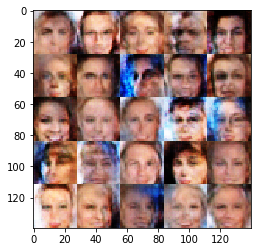

Epoch 2/3... Discriminator Loss: 1.3933... Generator Loss: 0.7358
Epoch 2/3... Discriminator Loss: 1.3764... Generator Loss: 0.7684
Epoch 2/3... Discriminator Loss: 1.3657... Generator Loss: 0.7563
Epoch 2/3... Discriminator Loss: 1.3690... Generator Loss: 0.8336
Epoch 2/3... Discriminator Loss: 1.3887... Generator Loss: 0.7966
Epoch 2/3... Discriminator Loss: 1.3852... Generator Loss: 0.7441
Epoch 2/3... Discriminator Loss: 1.3692... Generator Loss: 0.7758
Epoch 2/3... Discriminator Loss: 1.3739... Generator Loss: 0.7972
Epoch 2/3... Discriminator Loss: 1.4495... Generator Loss: 0.7329
Epoch 2/3... Discriminator Loss: 1.4085... Generator Loss: 0.8330


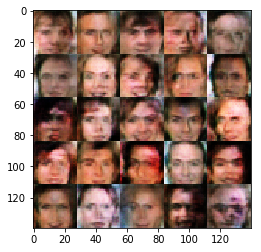

Epoch 2/3... Discriminator Loss: 1.4035... Generator Loss: 0.8169
Epoch 2/3... Discriminator Loss: 1.3701... Generator Loss: 0.8254
Epoch 2/3... Discriminator Loss: 1.3831... Generator Loss: 0.8506
Epoch 2/3... Discriminator Loss: 1.4241... Generator Loss: 0.8102
Epoch 2/3... Discriminator Loss: 1.3658... Generator Loss: 0.7432
Epoch 2/3... Discriminator Loss: 1.3972... Generator Loss: 0.8295
Epoch 2/3... Discriminator Loss: 1.3693... Generator Loss: 0.8796
Epoch 2/3... Discriminator Loss: 1.3977... Generator Loss: 0.7930
Epoch 2/3... Discriminator Loss: 1.3694... Generator Loss: 0.8058
Epoch 2/3... Discriminator Loss: 1.3906... Generator Loss: 0.8010


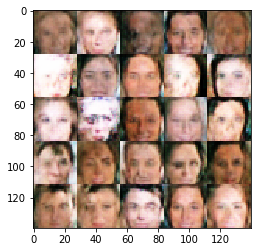

Epoch 2/3... Discriminator Loss: 1.4094... Generator Loss: 0.7080
Epoch 2/3... Discriminator Loss: 1.3954... Generator Loss: 0.7823
Epoch 2/3... Discriminator Loss: 1.3806... Generator Loss: 0.8072
Epoch 2/3... Discriminator Loss: 1.3730... Generator Loss: 0.7535
Epoch 2/3... Discriminator Loss: 1.3986... Generator Loss: 0.7153
Epoch 2/3... Discriminator Loss: 1.3728... Generator Loss: 0.8368
Epoch 2/3... Discriminator Loss: 1.4058... Generator Loss: 0.8301
Epoch 2/3... Discriminator Loss: 1.3484... Generator Loss: 0.8049
Epoch 2/3... Discriminator Loss: 1.3822... Generator Loss: 0.7656
Epoch 2/3... Discriminator Loss: 1.3897... Generator Loss: 0.7845


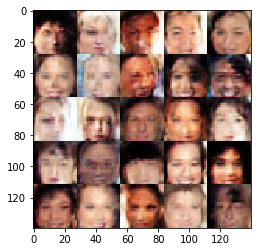

Epoch 2/3... Discriminator Loss: 1.3633... Generator Loss: 0.8948
Epoch 2/3... Discriminator Loss: 1.3969... Generator Loss: 0.7570
Epoch 2/3... Discriminator Loss: 1.4088... Generator Loss: 0.8116
Epoch 2/3... Discriminator Loss: 1.3731... Generator Loss: 0.7278
Epoch 2/3... Discriminator Loss: 1.3270... Generator Loss: 0.7752
Epoch 2/3... Discriminator Loss: 1.4011... Generator Loss: 0.7697
Epoch 2/3... Discriminator Loss: 1.4085... Generator Loss: 0.8110
Epoch 2/3... Discriminator Loss: 1.3952... Generator Loss: 0.7951
Epoch 2/3... Discriminator Loss: 1.4358... Generator Loss: 0.7679
Epoch 2/3... Discriminator Loss: 1.3716... Generator Loss: 0.8646


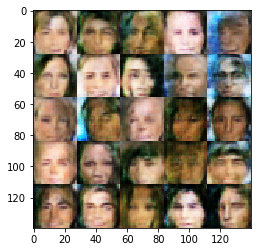

Epoch 2/3... Discriminator Loss: 1.3803... Generator Loss: 0.7861
Epoch 2/3... Discriminator Loss: 1.4060... Generator Loss: 0.8529
Epoch 2/3... Discriminator Loss: 1.3722... Generator Loss: 0.8411
Epoch 2/3... Discriminator Loss: 1.3863... Generator Loss: 0.8656
Epoch 2/3... Discriminator Loss: 1.4003... Generator Loss: 0.7952
Epoch 2/3... Discriminator Loss: 1.3897... Generator Loss: 0.8049
Epoch 2/3... Discriminator Loss: 1.4387... Generator Loss: 0.7421
Epoch 2/3... Discriminator Loss: 1.3592... Generator Loss: 0.7811
Epoch 2/3... Discriminator Loss: 1.4049... Generator Loss: 0.8061
Epoch 2/3... Discriminator Loss: 1.3815... Generator Loss: 0.7701


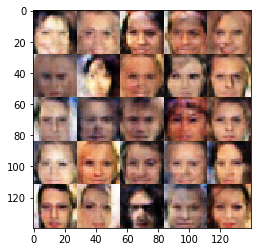

Epoch 2/3... Discriminator Loss: 1.3739... Generator Loss: 0.7773
Epoch 2/3... Discriminator Loss: 1.3722... Generator Loss: 0.8445
Epoch 2/3... Discriminator Loss: 1.4423... Generator Loss: 0.7560
Epoch 2/3... Discriminator Loss: 1.4278... Generator Loss: 0.7681
Epoch 2/3... Discriminator Loss: 1.3900... Generator Loss: 0.8256
Epoch 2/3... Discriminator Loss: 1.3937... Generator Loss: 0.7415
Epoch 2/3... Discriminator Loss: 1.3894... Generator Loss: 0.7609
Epoch 2/3... Discriminator Loss: 1.3789... Generator Loss: 0.8204
Epoch 2/3... Discriminator Loss: 1.3868... Generator Loss: 0.7846
Epoch 2/3... Discriminator Loss: 1.4221... Generator Loss: 0.7921


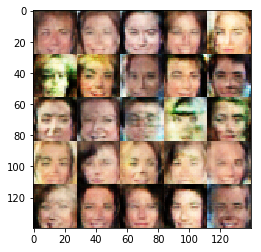

Epoch 2/3... Discriminator Loss: 1.3941... Generator Loss: 0.7796
Epoch 2/3... Discriminator Loss: 1.3884... Generator Loss: 0.8399
Epoch 2/3... Discriminator Loss: 1.3632... Generator Loss: 0.8405
Epoch 2/3... Discriminator Loss: 1.4020... Generator Loss: 0.8775
Epoch 2/3... Discriminator Loss: 1.3923... Generator Loss: 0.7837
Epoch 2/3... Discriminator Loss: 1.3949... Generator Loss: 0.7679
Epoch 2/3... Discriminator Loss: 1.4113... Generator Loss: 0.8365
Epoch 2/3... Discriminator Loss: 1.3488... Generator Loss: 0.7551
Epoch 2/3... Discriminator Loss: 1.4220... Generator Loss: 0.7649
Epoch 2/3... Discriminator Loss: 1.3967... Generator Loss: 0.7698


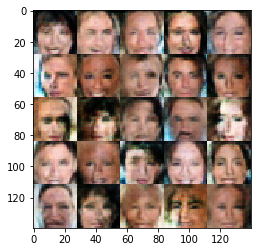

Epoch 2/3... Discriminator Loss: 1.3715... Generator Loss: 0.8330
Epoch 2/3... Discriminator Loss: 1.4497... Generator Loss: 0.7927
Epoch 2/3... Discriminator Loss: 1.3872... Generator Loss: 0.7487
Epoch 2/3... Discriminator Loss: 1.3897... Generator Loss: 0.8688
Epoch 2/3... Discriminator Loss: 1.4194... Generator Loss: 0.8034
Epoch 2/3... Discriminator Loss: 1.4064... Generator Loss: 0.8098
Epoch 2/3... Discriminator Loss: 1.3744... Generator Loss: 0.7885
Epoch 2/3... Discriminator Loss: 1.3934... Generator Loss: 0.8110
Epoch 2/3... Discriminator Loss: 1.4119... Generator Loss: 0.8191
Epoch 2/3... Discriminator Loss: 1.3859... Generator Loss: 0.6973


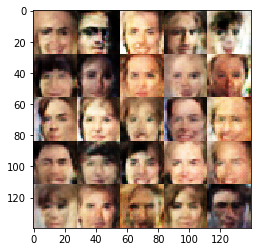

Epoch 2/3... Discriminator Loss: 1.4644... Generator Loss: 0.7472
Epoch 2/3... Discriminator Loss: 1.3761... Generator Loss: 0.7611
Epoch 2/3... Discriminator Loss: 1.3944... Generator Loss: 0.8209
Epoch 2/3... Discriminator Loss: 1.3799... Generator Loss: 0.7522
Epoch 2/3... Discriminator Loss: 1.3764... Generator Loss: 0.8799
Epoch 2/3... Discriminator Loss: 1.3797... Generator Loss: 0.8153
Epoch 2/3... Discriminator Loss: 1.4119... Generator Loss: 0.7716
Epoch 2/3... Discriminator Loss: 1.3871... Generator Loss: 0.8596
Epoch 2/3... Discriminator Loss: 1.3767... Generator Loss: 0.7313
Epoch 2/3... Discriminator Loss: 1.3668... Generator Loss: 0.8129


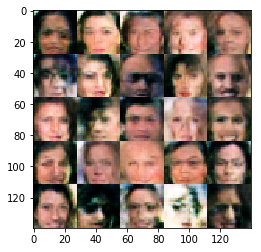

Epoch 2/3... Discriminator Loss: 1.3834... Generator Loss: 0.7617
Epoch 2/3... Discriminator Loss: 1.3621... Generator Loss: 0.8390
Epoch 2/3... Discriminator Loss: 1.3593... Generator Loss: 0.8167
Epoch 2/3... Discriminator Loss: 1.3759... Generator Loss: 0.7770
Epoch 2/3... Discriminator Loss: 1.3678... Generator Loss: 0.8170
Epoch 2/3... Discriminator Loss: 1.3623... Generator Loss: 0.7628
Epoch 2/3... Discriminator Loss: 1.3656... Generator Loss: 0.7970
Epoch 2/3... Discriminator Loss: 1.4289... Generator Loss: 0.8176
Epoch 2/3... Discriminator Loss: 1.4206... Generator Loss: 0.7528
Epoch 2/3... Discriminator Loss: 1.4262... Generator Loss: 0.7196


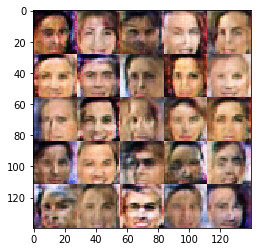

Epoch 2/3... Discriminator Loss: 1.3858... Generator Loss: 0.8150
Epoch 2/3... Discriminator Loss: 1.3874... Generator Loss: 0.7772
Epoch 2/3... Discriminator Loss: 1.3860... Generator Loss: 0.7623
Epoch 2/3... Discriminator Loss: 1.3791... Generator Loss: 0.7766
Epoch 2/3... Discriminator Loss: 1.3696... Generator Loss: 0.8108
Epoch 2/3... Discriminator Loss: 1.3797... Generator Loss: 0.8042
Epoch 2/3... Discriminator Loss: 1.3702... Generator Loss: 0.8077
Epoch 2/3... Discriminator Loss: 1.4056... Generator Loss: 0.7746
Epoch 2/3... Discriminator Loss: 1.3655... Generator Loss: 0.8275
Epoch 2/3... Discriminator Loss: 1.3652... Generator Loss: 0.8318


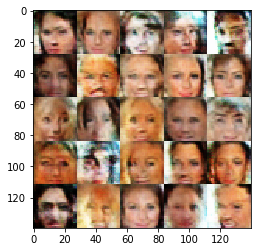

Epoch 2/3... Discriminator Loss: 1.4394... Generator Loss: 0.7219
Epoch 2/3... Discriminator Loss: 1.3800... Generator Loss: 0.8024
Epoch 2/3... Discriminator Loss: 1.3944... Generator Loss: 0.7510
Epoch 2/3... Discriminator Loss: 1.3608... Generator Loss: 0.8182
Epoch 2/3... Discriminator Loss: 1.3966... Generator Loss: 0.7533
Epoch 2/3... Discriminator Loss: 1.3901... Generator Loss: 0.8896
Epoch 2/3... Discriminator Loss: 1.4472... Generator Loss: 0.7803
Epoch 2/3... Discriminator Loss: 1.5407... Generator Loss: 0.6592
Epoch 2/3... Discriminator Loss: 1.3312... Generator Loss: 0.7613
Epoch 2/3... Discriminator Loss: 1.4603... Generator Loss: 0.8115


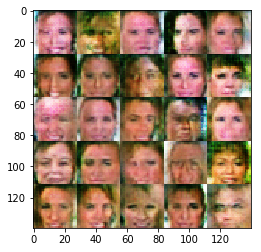

Epoch 2/3... Discriminator Loss: 1.3613... Generator Loss: 0.8514
Epoch 2/3... Discriminator Loss: 1.3474... Generator Loss: 0.7938
Epoch 2/3... Discriminator Loss: 1.4260... Generator Loss: 0.7313
Epoch 2/3... Discriminator Loss: 1.4494... Generator Loss: 0.7122
Epoch 2/3... Discriminator Loss: 1.4722... Generator Loss: 0.6935
Epoch 2/3... Discriminator Loss: 1.4673... Generator Loss: 0.7928
Epoch 2/3... Discriminator Loss: 1.3968... Generator Loss: 0.7169


In [ ]:
batch_size = 32
z_dim = 50
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.